## Analysis of distal lung epithelial cells 7 weeks after KrasG12D induction

### Set up the environment

In [27]:
# Derived from https://scanpy.readthedocs.io/en/stable/tutorials.html

# Count matrices were generated using CellRanger Count (see 10X Genomics website)

# import packages 
import scanpy.external as sce
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler
from seaborn import despine
from seaborn import axes_style
from matplotlib.pyplot import suptitle
import magic # imputation tool; van Dijk et al 2018 # 
import matplotlib.colors

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.2 scipy==1.3.0 pandas==0.23.4 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


## Pre-processing the data

reading AM1_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
reading AM2_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
reading AM4_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)
reading AM5_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Making variable names unique for controlled concatenation.
... storing 'feature_types' as categorical
... storing 'genome' as categorical


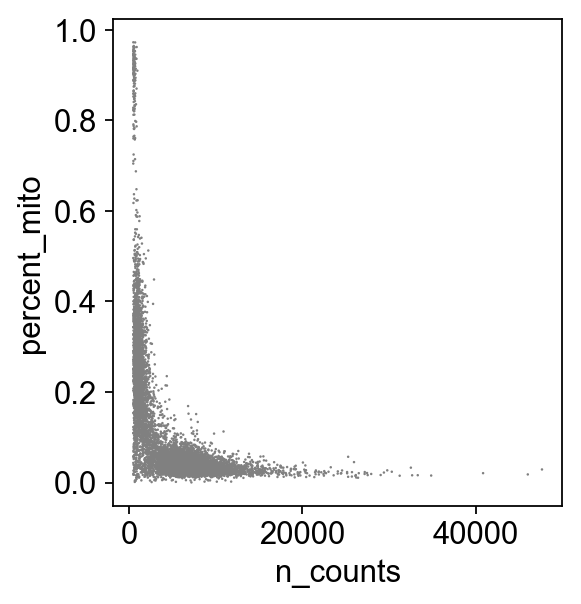

filtered out 11578 genes that are detectedin less than 3 cells


Trying to set attribute `.var` of view, making a copy.


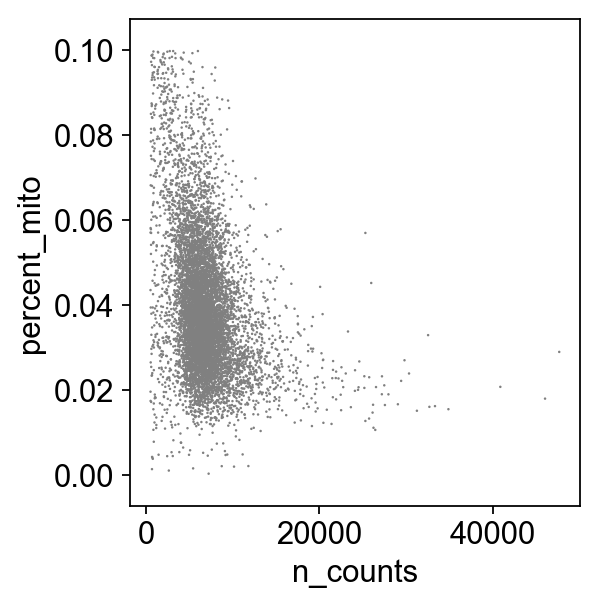

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 50
    finished (0:00:15)


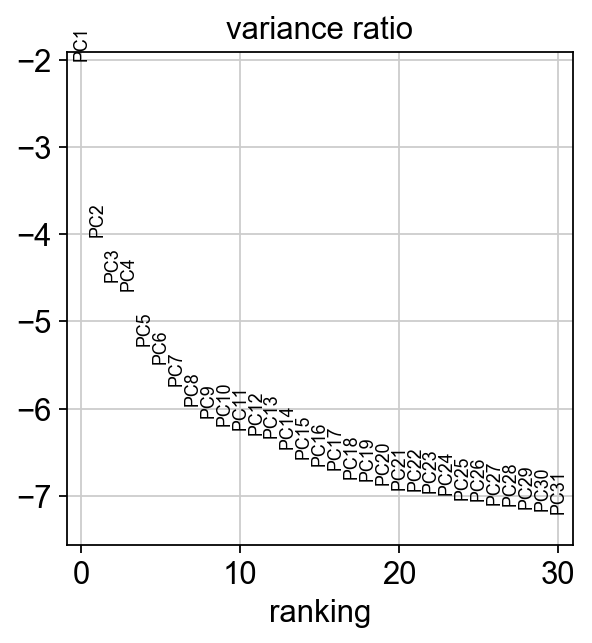

In [28]:
# package versions used for this analysis
# scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.2 scipy==1.3.0 pandas==0.23.4 scikit-learn==0.20.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1

#load and merge files

# CellRanger output
filenames = [
'AM1_filtered_feature_bc_matrix.h5',
'AM2_filtered_feature_bc_matrix.h5',
'AM4_filtered_feature_bc_matrix.h5',    
'AM5_filtered_feature_bc_matrix.h5',
]
adatas = [sc.read_10x_h5(filename) for filename in filenames]

adata = adatas[0].concatenate(adatas[1:],batch_categories=["Mouse 1 YFP neg","Mouse 1 YFP pos","Mouse 2 YFP neg","Mouse 2 YFP pos"])

# make sure gene names are unique
adata.var_names_make_unique()  

# compute %mito and remove cells with >10%
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

# plot mitochondrial content (y-axis) against read count before and after filtering cells with > 10% mitochondrial gene expression
# Cells wth >10% mito expression also has low read count indicating bad/dead cells rather than cells requiring more energy
sc.settings.set_figure_params(dpi=80)
with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, y='percent_mito', x='n_counts', size=5)

adata = adata[adata.obs['percent_mito'] < 0.1, :]
sc.pp.filter_genes(adata, min_cells=3)

with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, y='percent_mito', x='n_counts', size=5)

# Normalize the data, save raw data, then use data diffusion tool (van Dijk et al 2018)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

# No consensus about gene scaling so I did not scale the data. Read https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6582955/
# Not scaling argueably retains biological information
# Cell cycle is useful information and was not regressed in this analysis

# save current data as adata.raw
adata.raw = adata

sc.tl.pca(adata, svd_solver='arpack') # svd_solver='arpack' is important for reproducibility
sc.pl.pca_variance_ratio(adata, log=True) # find significant pc's

In [29]:
# Perform data diffusion. t=3 is sufficient to remove zero counts
# data diffusion tool is in scanpy.external 
sce.pp.magic(adata, name_list='all_genes', k=3, t=3, n_pca=30) # default settings

computing PHATE
    finished (0:00:06)


### Visualize correlations

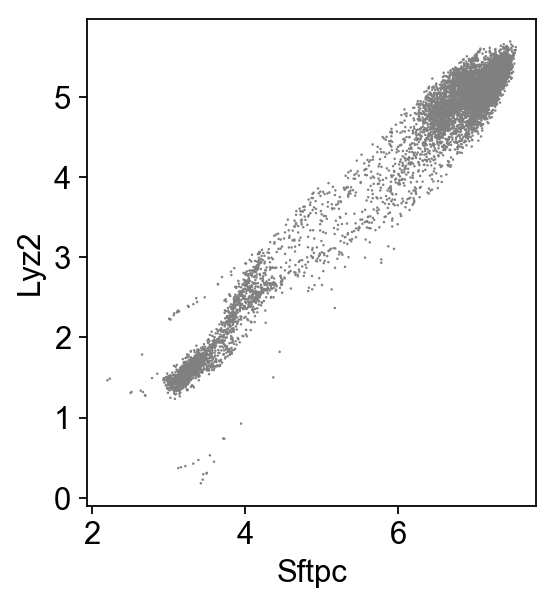

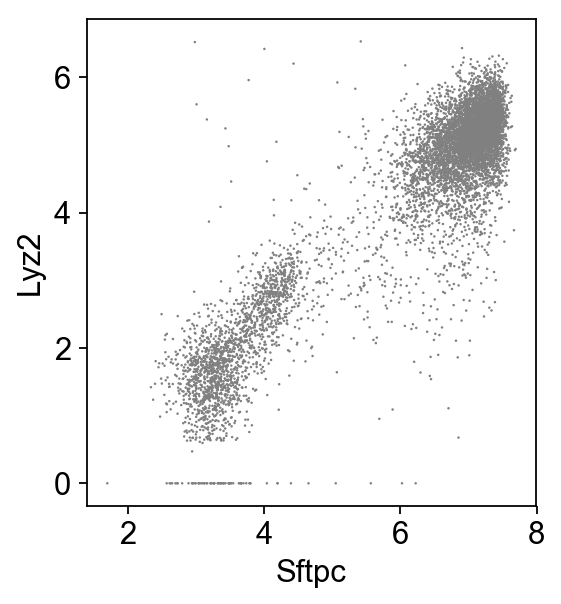

In [30]:
# After MAGIC
with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, x='Sftpc', y='Lyz2', size=5, use_raw=False)

# Before MAGIC
with axes_style({'axes.grid': False}):
 sc.pl.scatter(adata, x='Sftpc', y='Lyz2', size=5, use_raw=True)

In [31]:
#Intial filter
sc.pp.filter_cells(adata, min_genes=200)

# create nearest neighbors graph 
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=30)

# run louvain community detection algorithm
sc.tl.louvain(adata, resolution=0.01, key_added='louvain_r0.01')
sc.tl.louvain(adata, resolution=0.025, key_added='louvain_r0.025')
sc.tl.louvain(adata, resolution=0.05, key_added='louvain_r0.05')
sc.tl.louvain(adata, resolution=0.1, key_added='louvain_r0.1')
sc.tl.louvain(adata, resolution=0.2, key_added='louvain_r0.2')
sc.tl.louvain(adata, resolution=0.3, key_added='louvain_r0.3')
sc.tl.louvain(adata, resolution=0.4, key_added='louvain_r0.4')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

# Visualize different Louvain resolutions using UMAP
sc.tl.umap(adata)

sc.settings.set_figure_params(dpi=80) # aesthetic

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
computing UMAP
    finished (0:00:07)


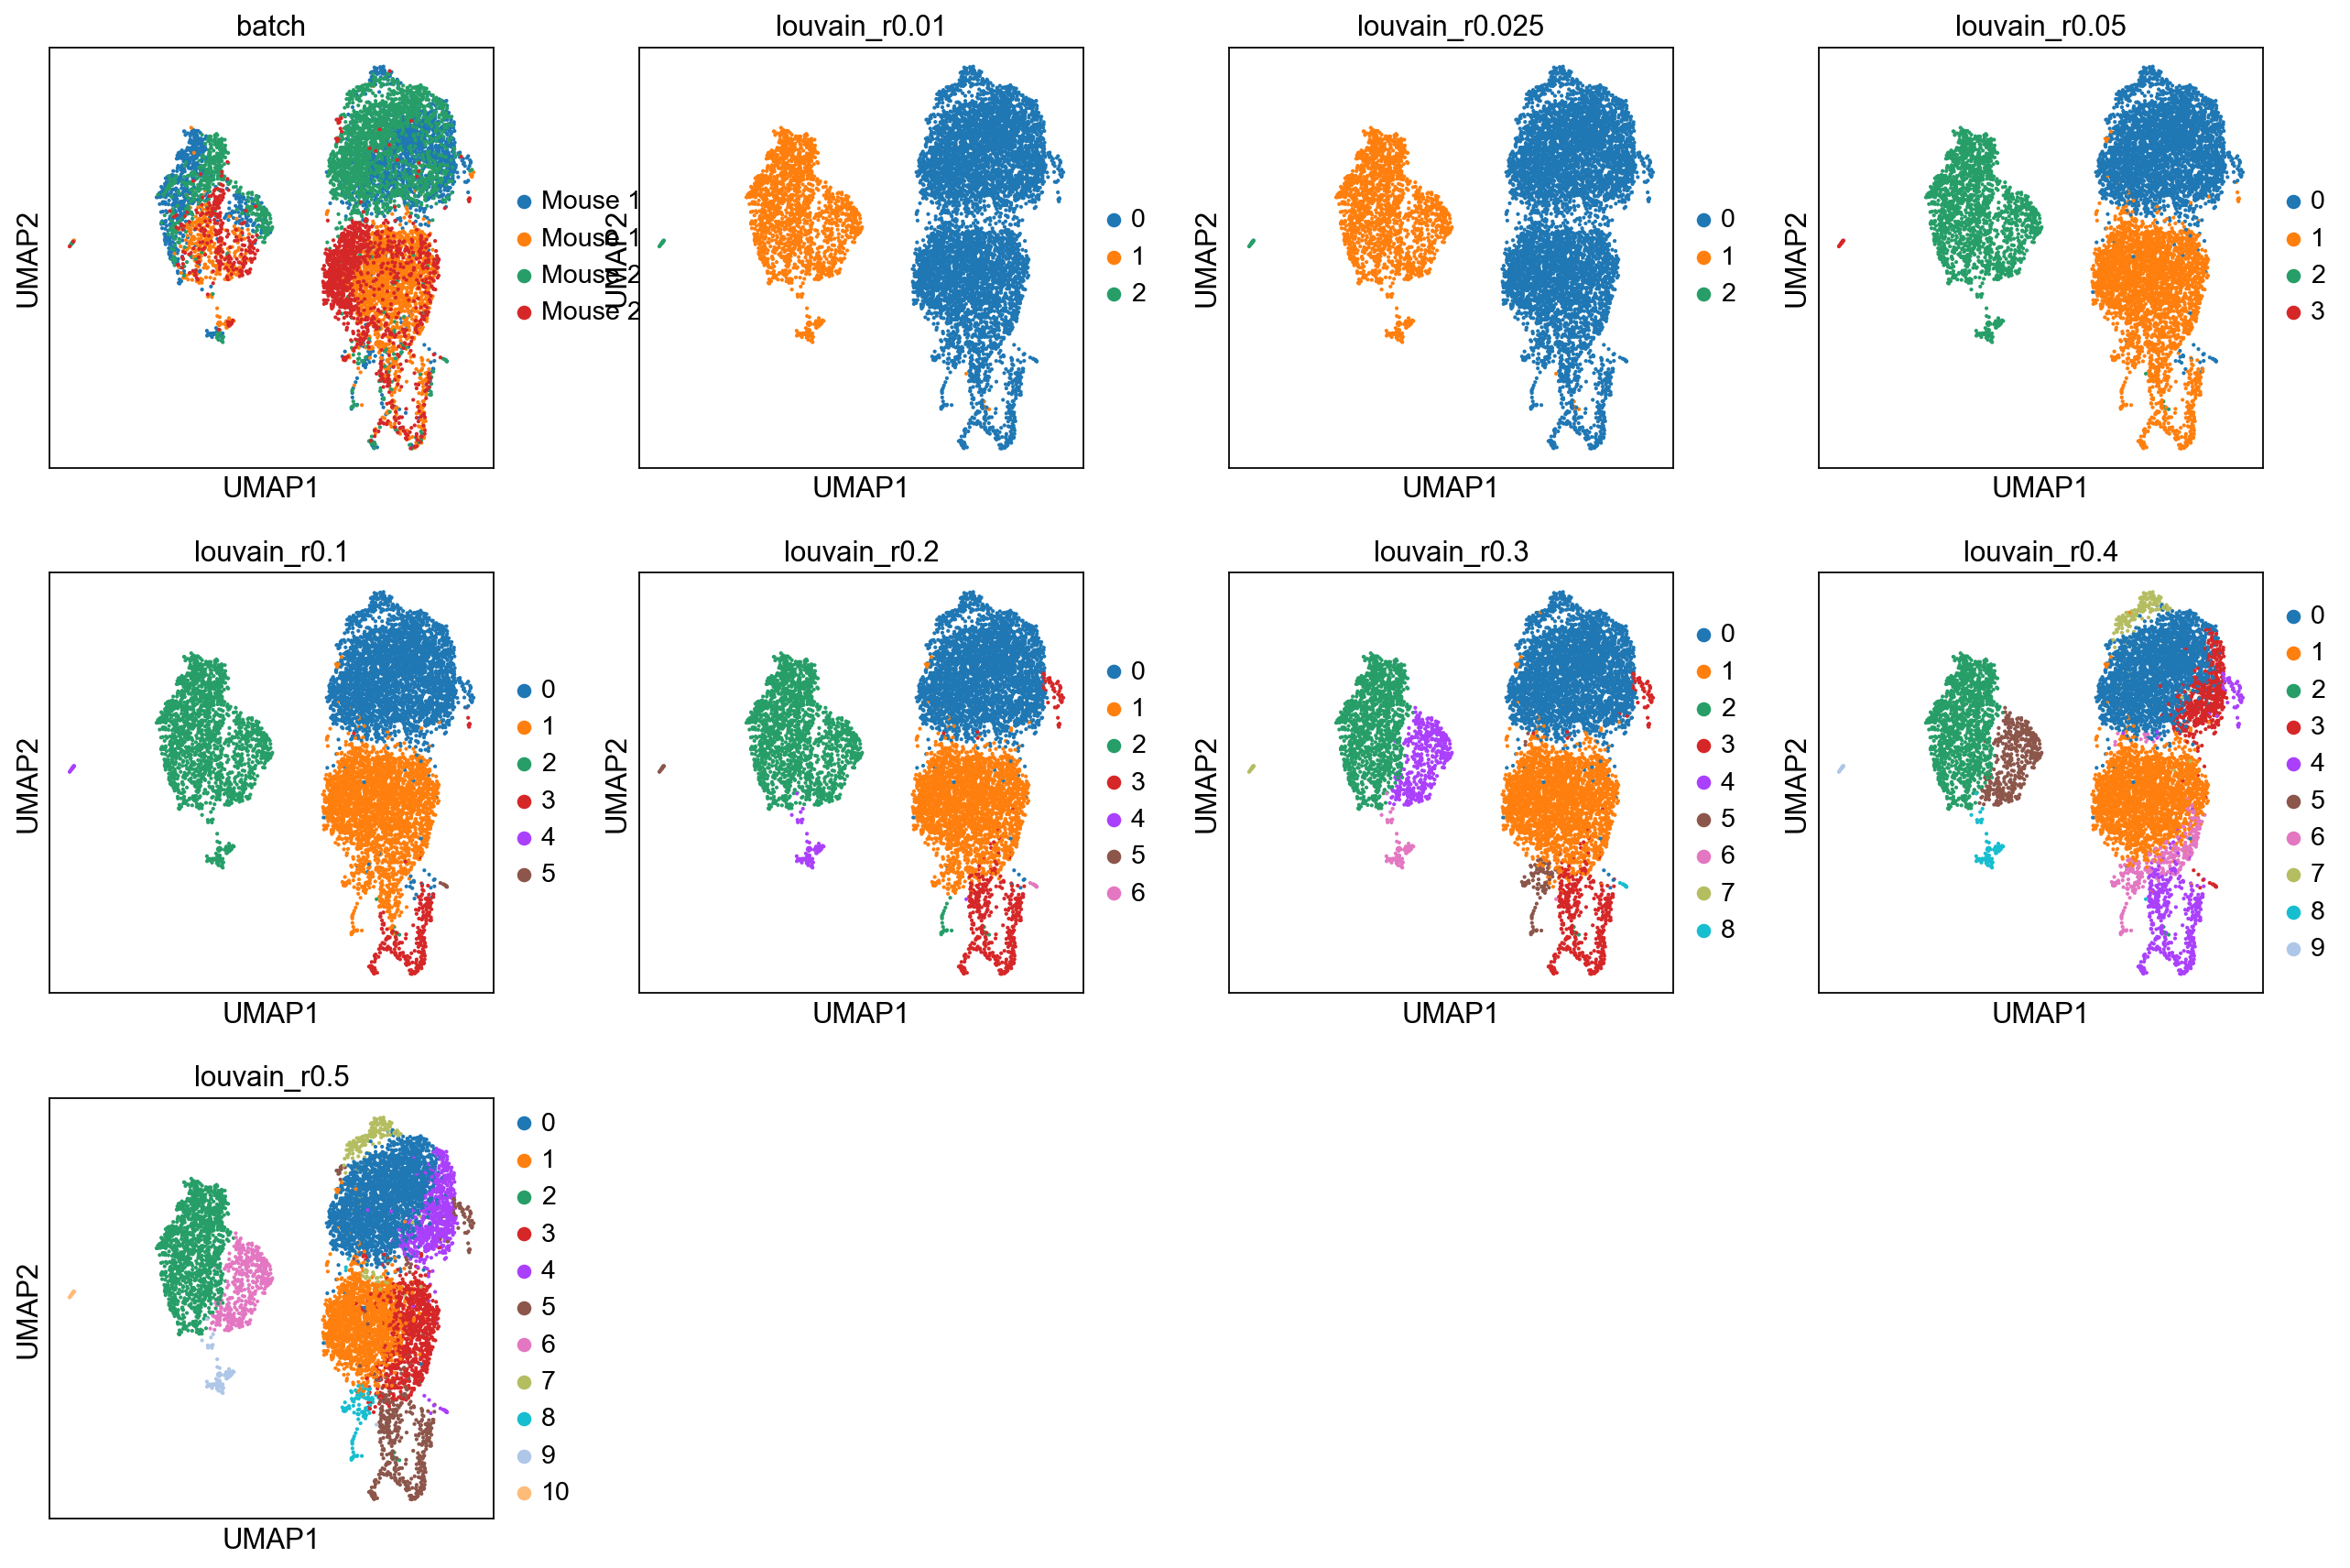

In [32]:
# Visualize
sc.pl.umap(adata, color=['batch','louvain_r0.01','louvain_r0.025','louvain_r0.05','louvain_r0.1','louvain_r0.2','louvain_r0.3','louvain_r0.4','louvain_r0.5'])

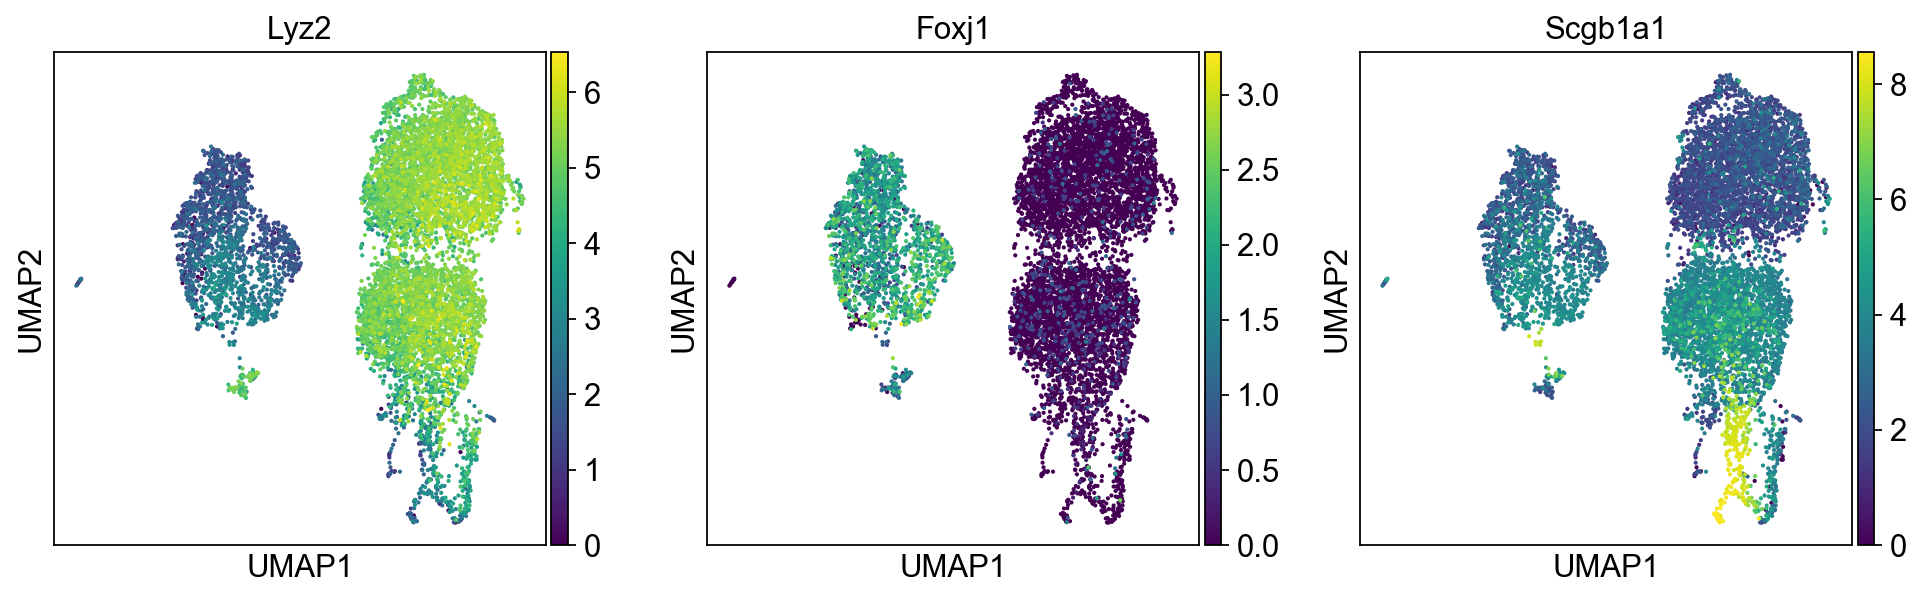

In [33]:
# Check signature gene expression
sc.pl.umap(adata, color=['Lyz2','Foxj1','Scgb1a1'])

running PAGA
    finished (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


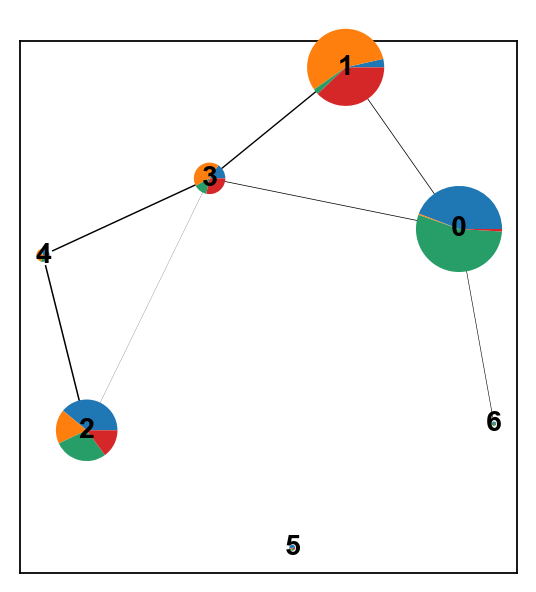

computing UMAP
    finished (0:00:07)


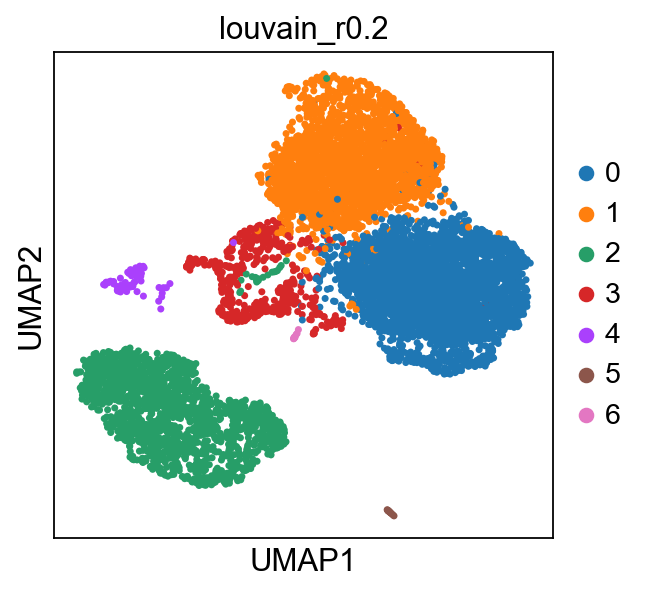

In [34]:
# Create a PAGA-initialized UMAP embedding (Wolf et al. 2018 Genome Biology). 

# Louvain_r0.2 was chosen based on signature gene expression

sc.tl.paga(adata, groups='louvain_r0.2')
sc.pl.paga(adata, plot=True, color=['batch'])

# sc.tl.umap(adata, init_pos='paga') is not working (August 7, 2019) https://github.com/theislab/scanpy/issues/769 = work around for now..

sc.tl.umap(adata, init_pos=sc.tl._utils.get_init_pos_from_paga(adata))
sc.pl.umap(adata, frameon=True, color=['louvain_r0.2'], legend_loc='right margin', size=40) # louvain


In [26]:
# counts cells per cluster then remove any clusters with less than 100 cells
adata.obs['louvain_r0.2'].value_counts()

0    3402
1    2731
2    1740
3     455
4      80
5      16
6       9
Name: louvain_r0.2, dtype: int64

#### Remove small clusters then save adata and adata_subset

In [36]:
adata_subset = adata[adata.obs['louvain_r0.2'].isin(['0','1','2','3'])] # remove small clusters

#### Plot UMAP showing batch and Louvain cluster information

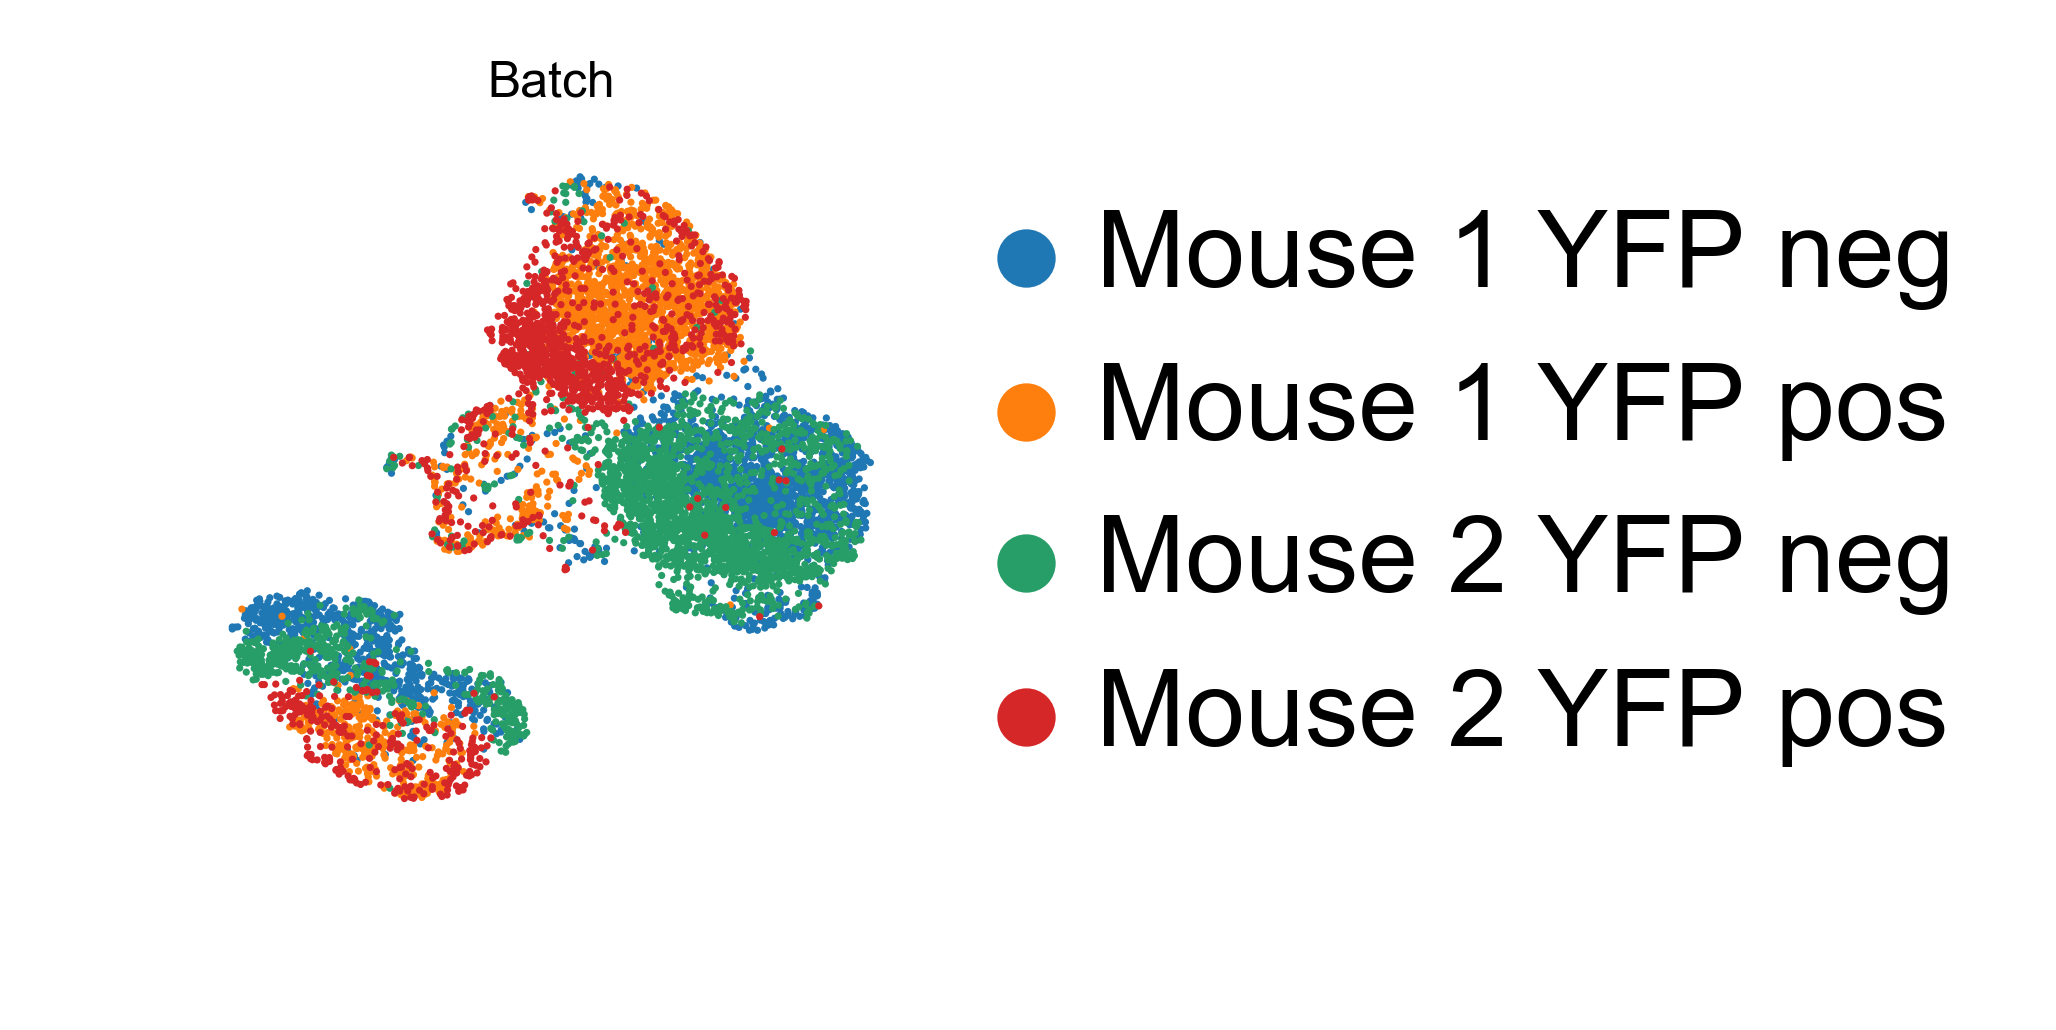

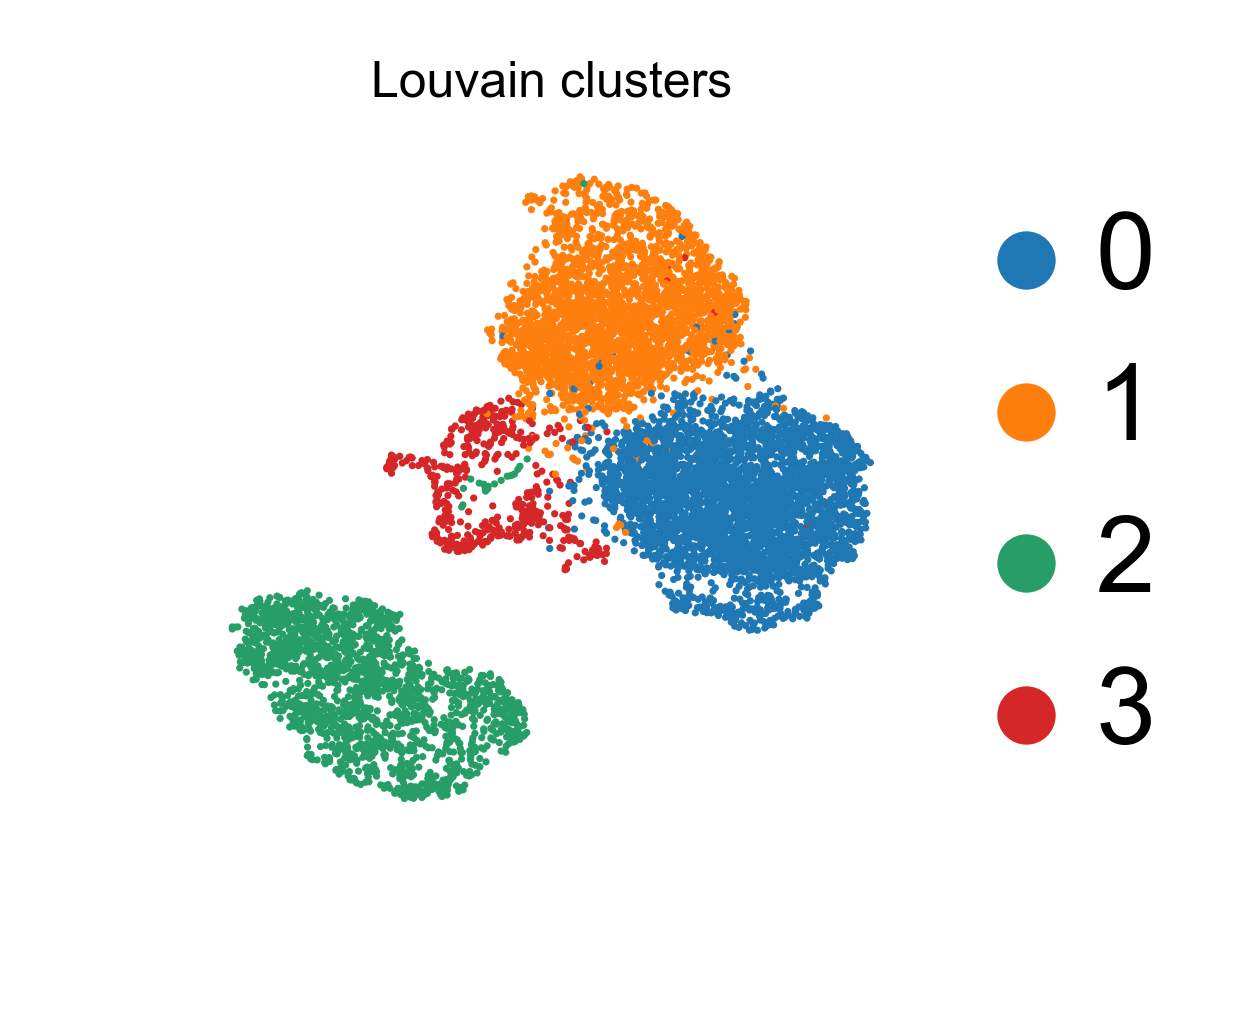

In [255]:
# Plot louvain and batch

sc.set_figure_params(dpi=300) # aesthetic

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['blue','lightcoral','red']) 
use_raw='False'
frameon=False
size=3 
figsize=1.5,1.5
fontsize=6
dpi=300
tick_size=5 # https://github.com/theislab/scanpy/issues/337

rcParams['figure.figsize']=figsize
ax=sc.pl.umap(adata_subset, color=['batch'],frameon=frameon,  
use_raw=use_raw, size=size, show=False)
plt.title('Batch', fontsize=fontsize)
ax.tick_params(labelsize=tick_size)
fig = plt.gcf()
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=tick_size)
plt.savefig('./figures/umap_batch.png', bbox_inches='tight', dpi=dpi)

rcParams['figure.figsize']=figsize
ax=sc.pl.umap(adata_subset, color=['louvain_r0.2'], frameon=frameon, 
use_raw=use_raw, size=size, show=False)
plt.title('Louvain clusters', fontsize=fontsize)
ax.tick_params(labelsize=tick_size)
fig = plt.gcf()
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=tick_size)
plt.savefig('./figures/umap_louvain.png', bbox_inches='tight', dpi=dpi)

#### Compute a hierarchical clustering for Louvain clusters and visualize results

In [40]:
sc.tl.dendrogram(adata_subset, n_pcs=30, groupby='louvain_r0.2')

    using 'X_pca' with n_pcs = 30
Storing dendrogram info using `.uns['dendrogram_louvain_r0.2']`


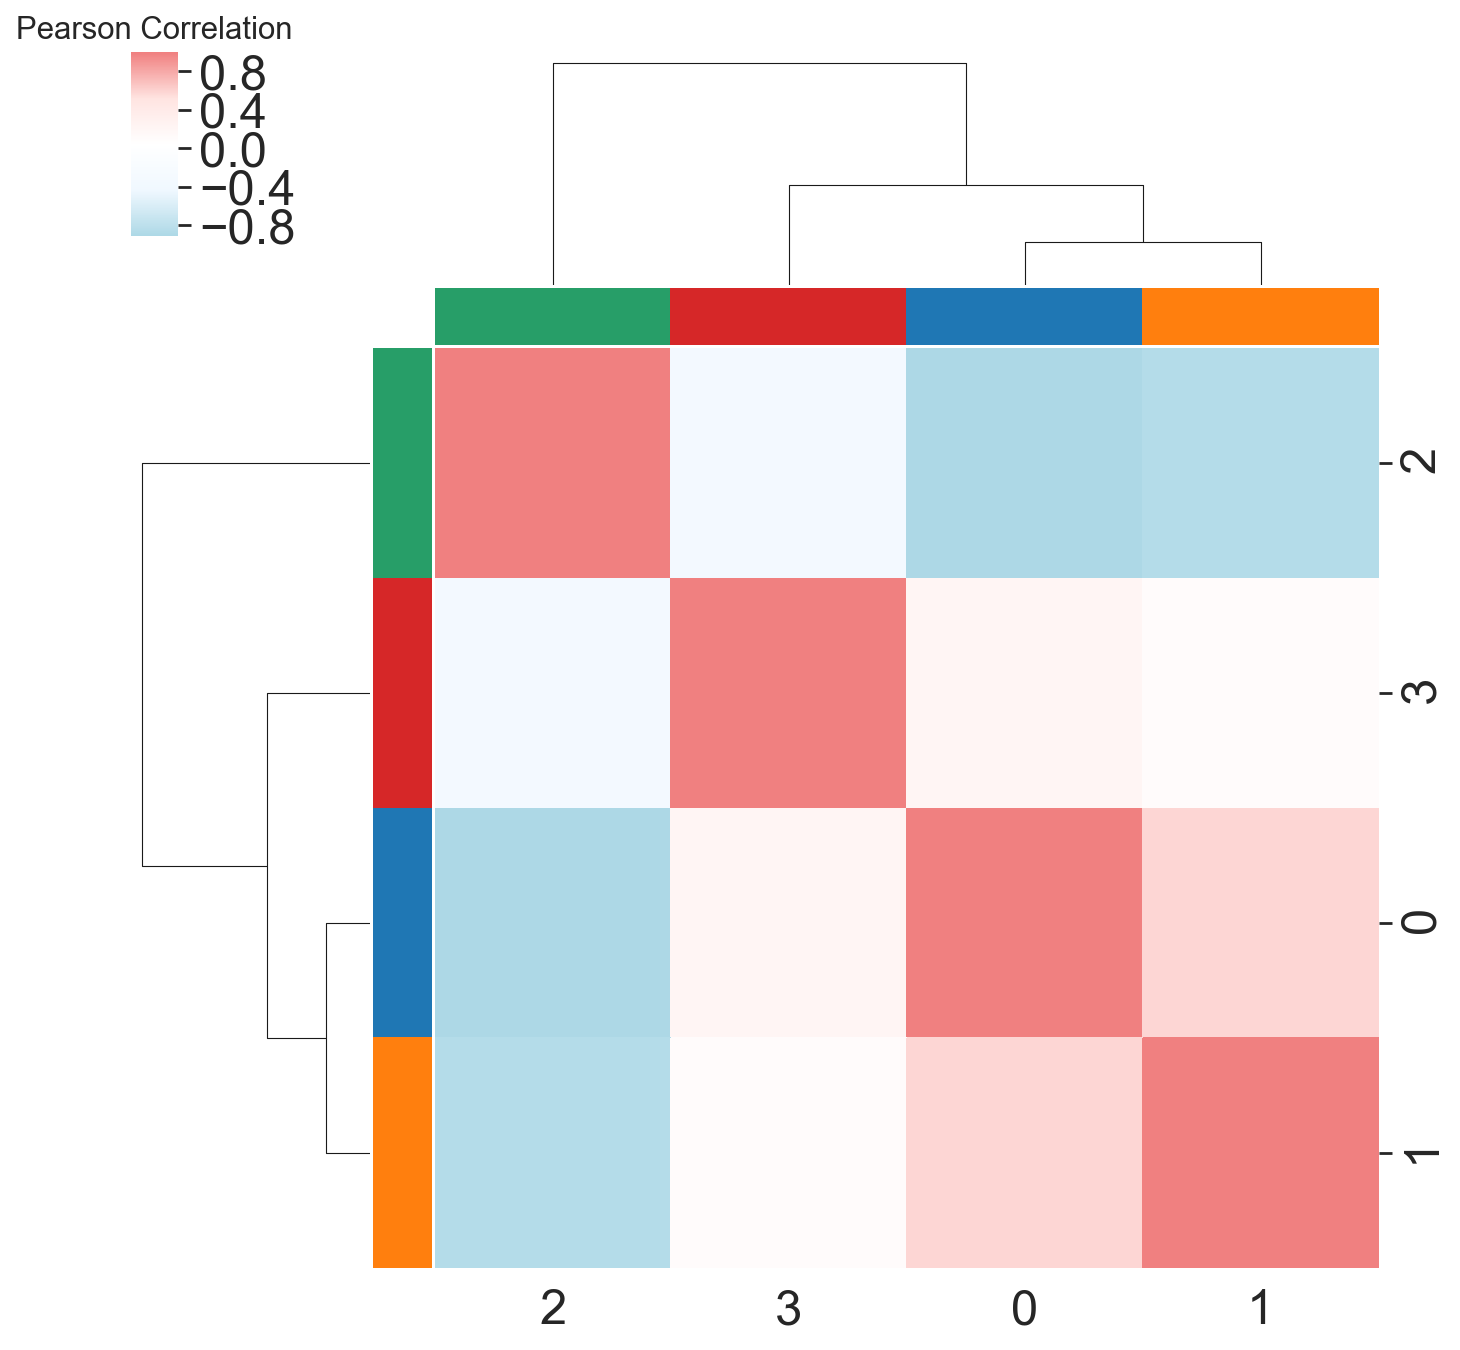

In [312]:
sb.set(font_scale=2) # change text size
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["lightblue",'aliceblue','white','mistyrose',"lightcoral"]) #color 
g = sb.clustermap(
adata_subset.uns['dendrogram_louvain_r0.2']['correlation_matrix'],
row_linkage=adata_subset.uns['dendrogram_louvain_r0.2']['linkage'], 
col_linkage=adata_subset.uns['dendrogram_louvain_r0.2']['linkage'],
yticklabels=adata_subset.obs['louvain_r0.2'].cat.categories,
xticklabels=adata_subset.obs['louvain_r0.2'].cat.categories,
annot=False,
cmap=cmap,
row_colors=adata_subset.uns['louvain_r0.2_colors'],
col_colors=adata_subset.uns['louvain_r0.2_colors'],
cbar_kws={'label': ''})
plt.title('Pearson Correlation', fontsize=14) # color bar title
plt.savefig('./figures/correlation_plot.png', bbox_inches='tight', dpi=300) # save

#### Identify clusters using well known marker genes

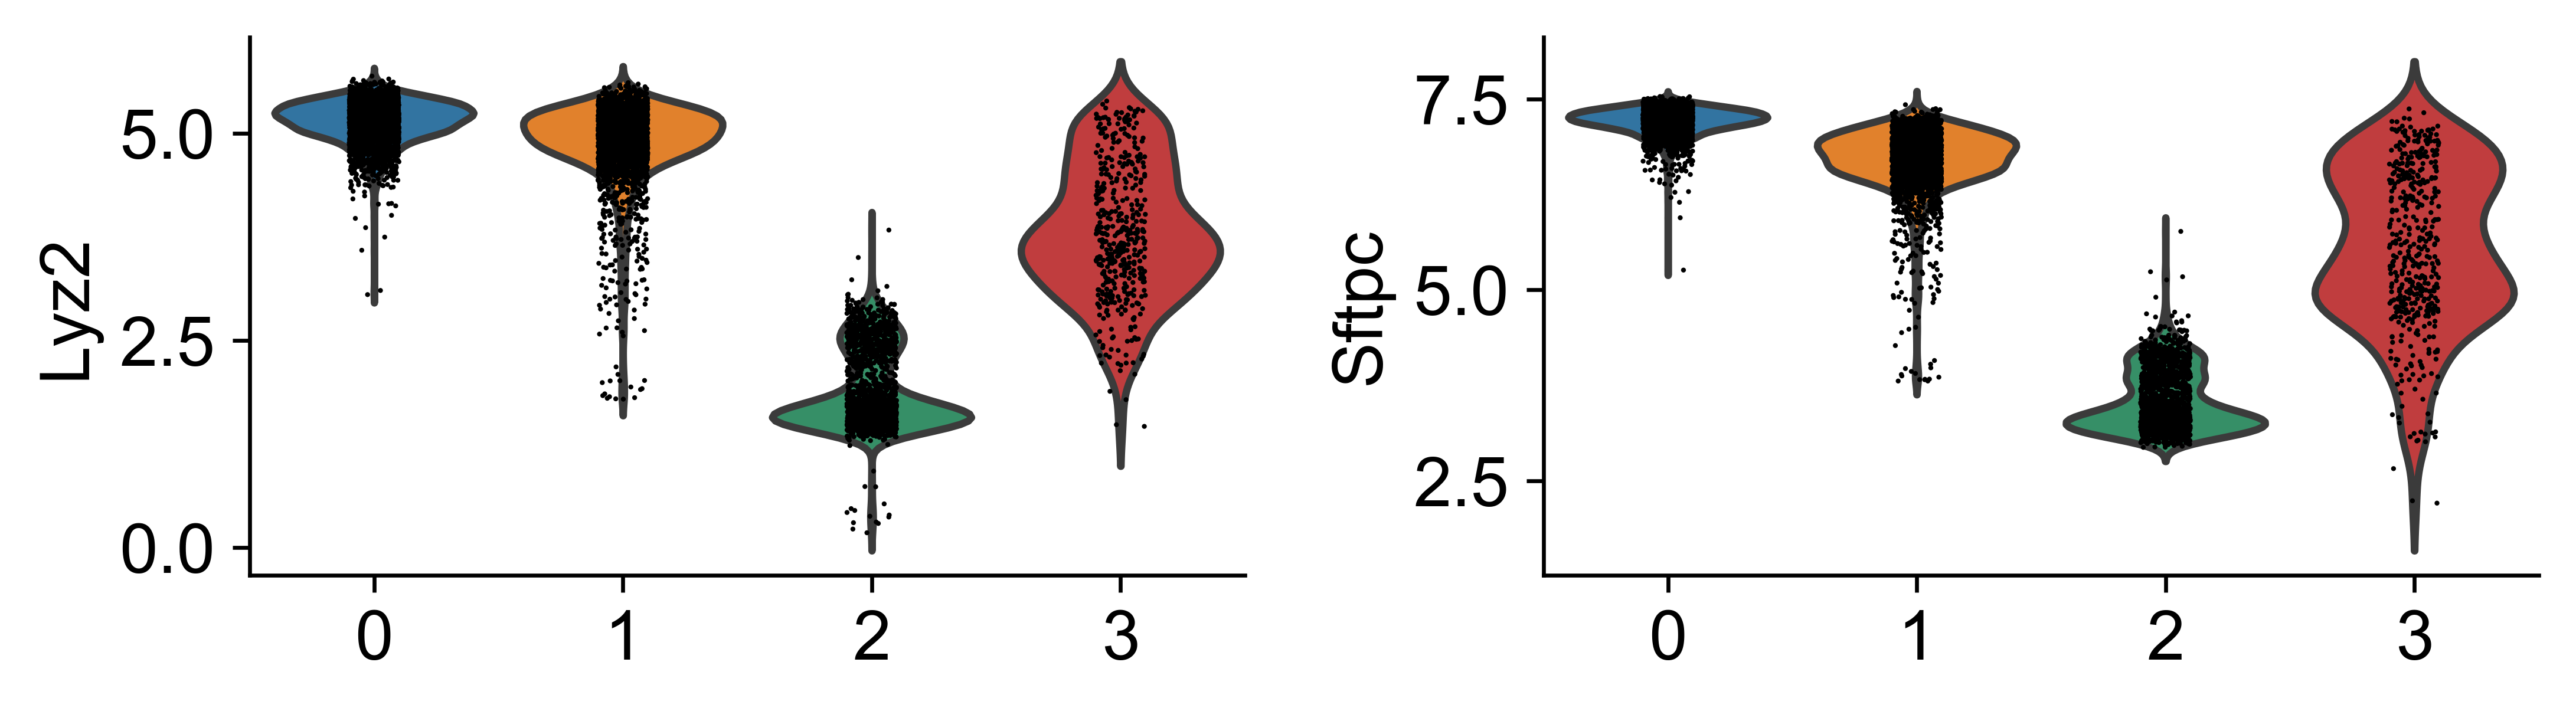

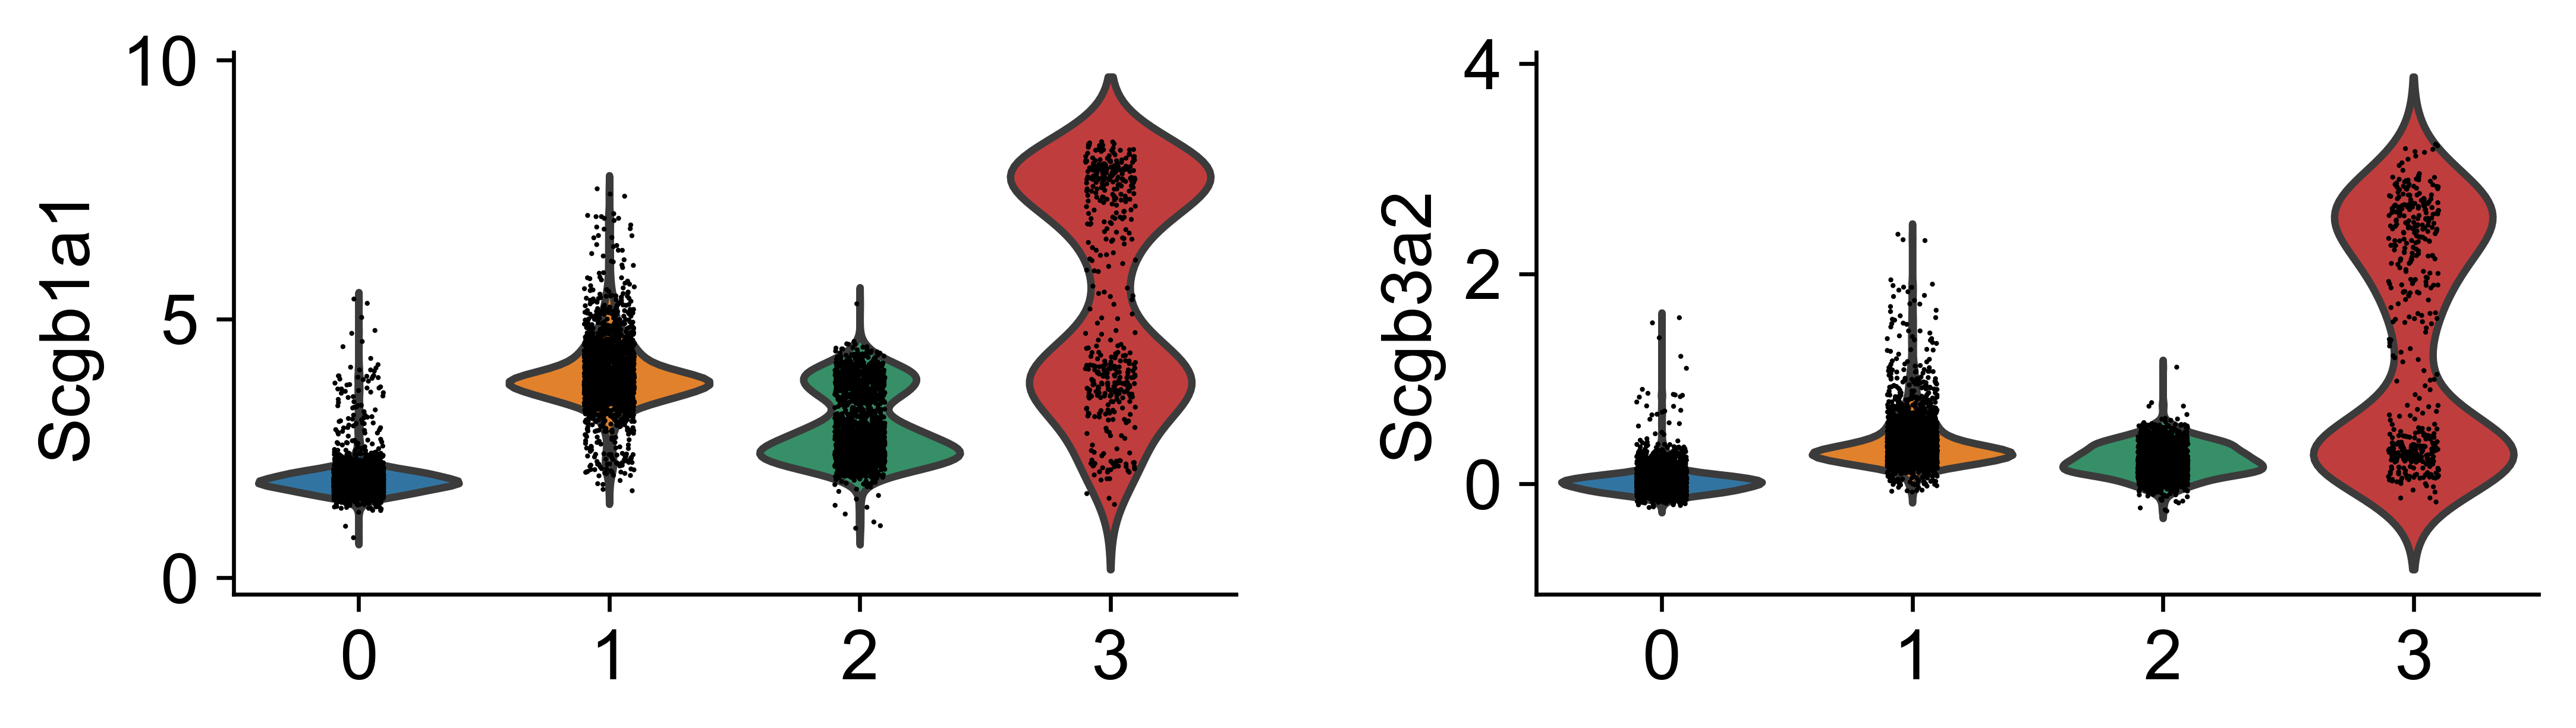

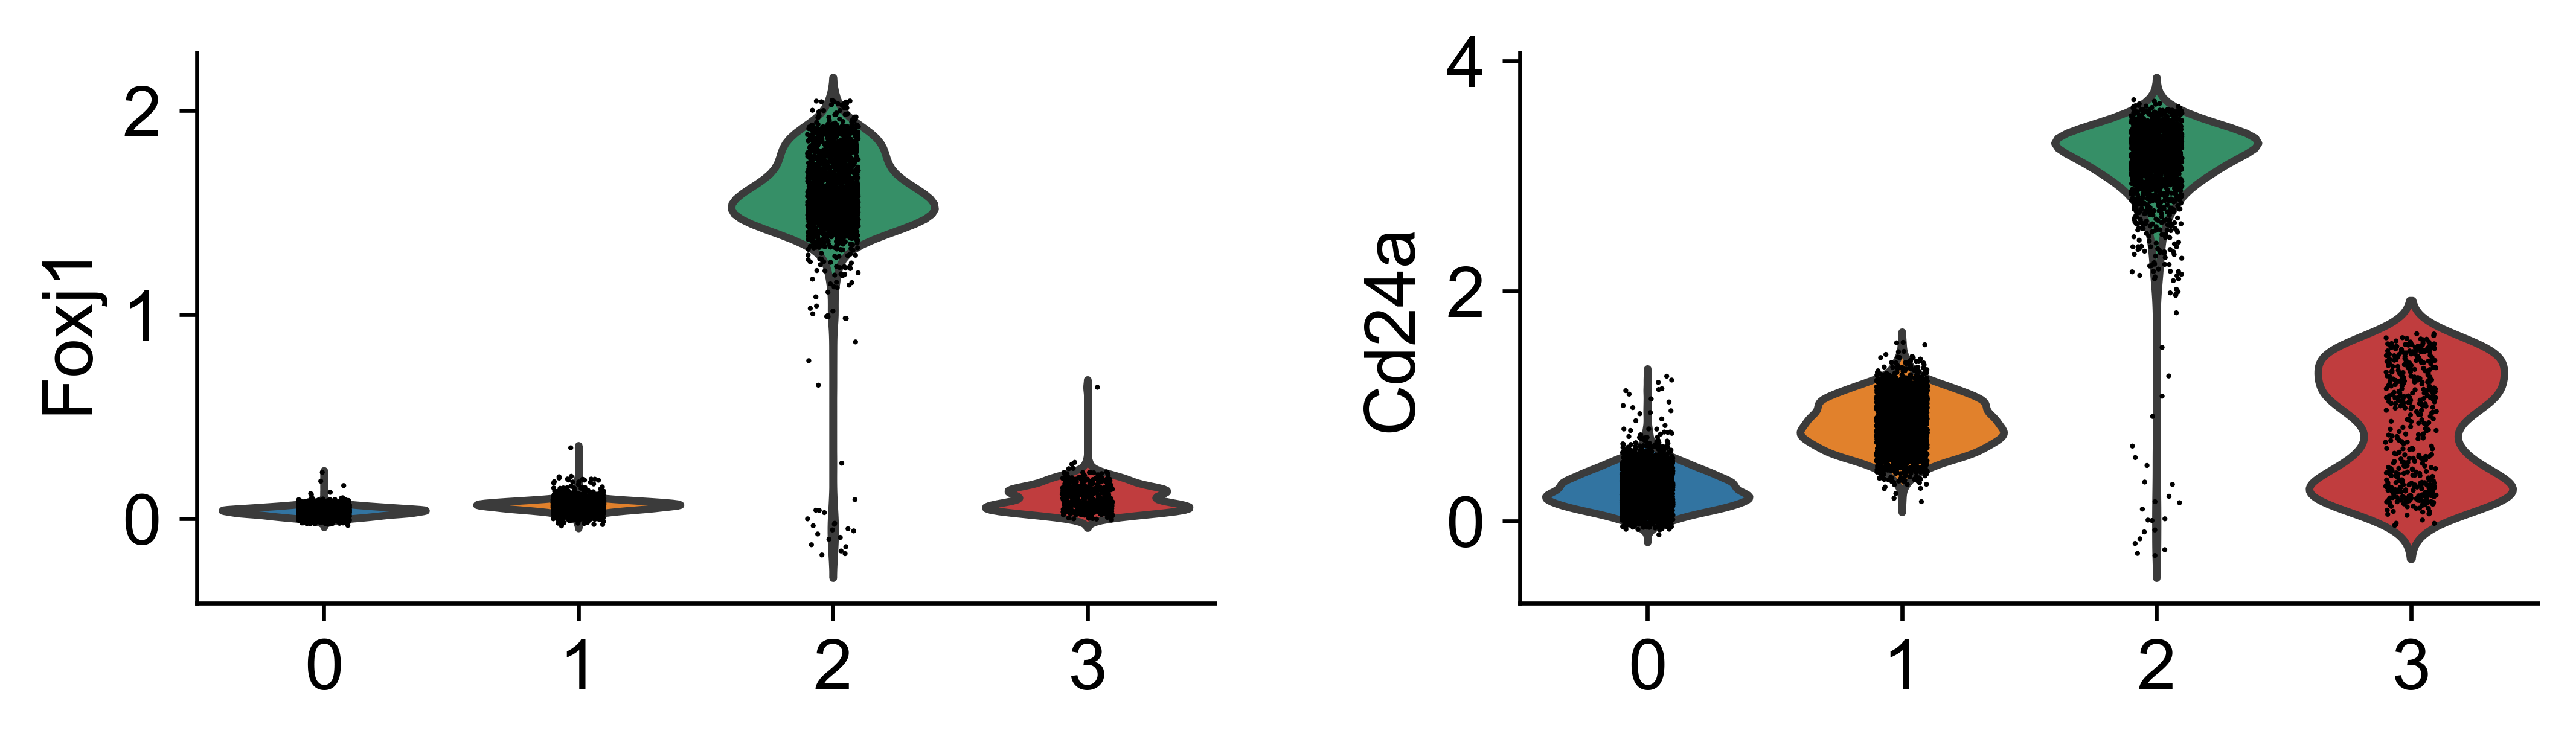

In [260]:
dpi=300 # image export quality

# Alveolar type 2 cells
rcParams['figure.figsize'] = 4,2
with axes_style({'axes.grid': False}):
 ax=sc.pl.violin(adata_subset, ['Lyz2','Sftpc'], groupby='louvain_r0.2', use_raw=False, size = 1, show=False, 
 rotation = 0)
despine(right=True)
plt.savefig('./figures/at2genes.png', bbox_inches='tight', dpi=dpi)

# Club cells
rcParams['figure.figsize'] = 4,2
with axes_style({'axes.grid': False}):
 ax=sc.pl.violin(adata_subset, ['Scgb1a1','Scgb3a2'], groupby='louvain_r0.2', use_raw=False, size = 1, show=False, 
 rotation = 0)
despine(right=True)
plt.savefig('./figures/clubgenes.png', bbox_inches='tight', dpi=dpi)

# Ciliated cells
rcParams['figure.figsize'] = 4,2
with axes_style({'axes.grid': False}):
 ax=sc.pl.violin(adata_subset, ['Foxj1','Cd24a'], groupby='louvain_r0.2', use_raw=False, size = 1, show=False, 
 rotation = 0)
despine(right=True)
plt.savefig('./figures/ciliatedgenes.png', bbox_inches='tight',dpi=dpi)

#### Visualize contirbutions of YFP+ and YFP- cells to each Louvain cluster

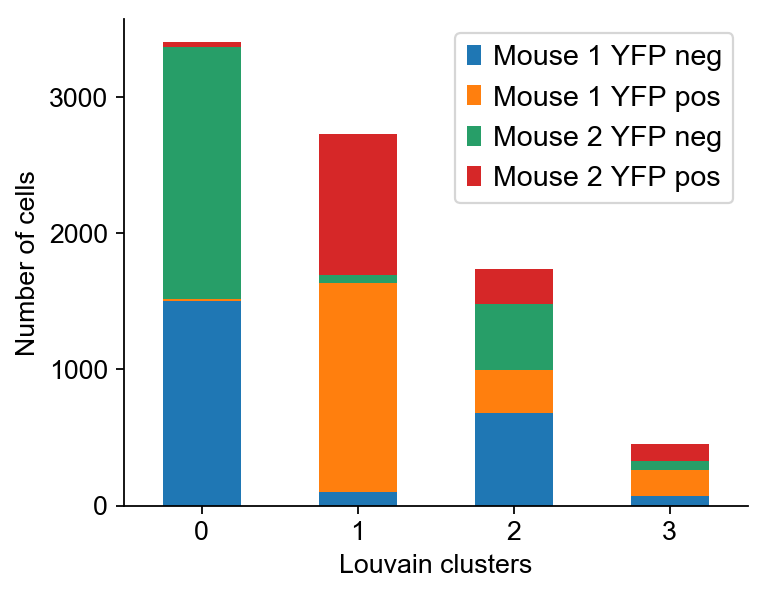

In [303]:
# Group by batch and louvain clusters
df=adata_subset.obs
df_plot = df.groupby(['batch', 'louvain_r0.2']).size().reset_index().pivot(columns='batch', index='louvain_r0.2', values=0)

# Visualize data
rcParams['figure.figsize'] = 5,4
with axes_style({'axes.grid': False}):
 df_plot.plot(kind='bar', stacked=True)
despine(right=True)
plt.ylabel('Number of cells', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.legend( loc = 'right margin')
plt.savefig('./figures/cluster_contributions.png', bbox_inches='tight', dpi=300)

## Downstream Analysis

### Calculating Gene Signatures

In [60]:
# Calculating z-scores for single cells

# Create an index column. Needed for single cell z-scoring
adata_subset.obs['index1'] = adata_subset.obs.index

# Prepare gene lists
TTRUST_sox9 = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='Sox9 targets TRRUST', header=0)
TTRUST_rela = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='Rela targets NFKB TRRUST', header=0)
bild_kras_list = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='Bild et al. 2006 (Kras genes)', header=0)
PLDB = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='AT2 marker genes (PanglaoDB)', header=0)

# sox9 list
TTRUST_activation_sox9 = TTRUST_sox9.loc[(TTRUST_sox9['Type'] == 'Activation')] # Subset genes that are activated
TTRUST_activation_sox9_list = TTRUST_activation_sox9['Target'].tolist() # Make list for visualization
TTRUST_activation_sox9_list = [x for x in TTRUST_activation_sox9_list if x in adata.var_names] # remove genes not expressed

# rela list
TTRUST_activation_rela = TTRUST_rela.loc[(TTRUST_rela['Type'] == 'Activation')] # Subset genes that are activated
TTRUST_activation_rela_list = TTRUST_activation_rela['Target'].tolist() # Make list for visualization
TTRUST_activation_rela_list = [x for x in TTRUST_activation_rela_list if x in adata.var_names] # remove genes not expressed

# kras list
bild_kras_list = bild_kras_list['GeneSymbol'].tolist() # Make list of gene names
bild_kras_list = [x.lower() for x in bild_kras_list] # lower names
bild_kras_list = [x.capitalize() for x in bild_kras_list] # capitalize names
bild_kras_list_final = [x for x in bild_kras_list if x in adata.var_names] # remove genes not in adata.var

# AT2 signature
PLDB_AT2 = PLDB.loc[(PLDB['cell type'] == 'Pulmonary alveolar type II cells') & (PLDB['species'] != 'Hs')] # Select mouse AT2 genes from database
PLDB_AT2_list = PLDB_AT2['official gene symbol'].tolist() # Make list of gene names
PLDB_AT2_list = [x.lower() for x in PLDB_AT2_list] # lower names
PLDB_AT2_list = [x.capitalize() for x in PLDB_AT2_list] # capitalize names
PLDB_AT2_list_final = [x for x in PLDB_AT2_list if x in adata.var_names] # remove genes not in adata.var

# Calculating z-scores for single cells

# create the marker dict 
marker_genes = dict()
marker_genes['Proliferation signature'] = ['Pbk','Birc5','Mki67','Ube2c','Top2a','Tk1','Aurkb','Cdkn3','Cenpf','Cdk1','Zwint']
marker_genes['Sox9_score'] = TTRUST_activation_sox9_list
marker_genes['Nfkb activation signature'] = TTRUST_activation_rela_list
marker_genes['Kras activation signature'] = bild_kras_list_final
marker_genes['AT2 signature'] = PLDB_AT2_list_final

# Calculate score
def evaluate_partition(anndata, marker_dict, gene_symbol_key=None, partition_key=None):
    # Inputs:
    #    anndata         - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or 
    #                      an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker 
    #                      genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                      'louvain_r1' 

    #Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please tell pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise
        

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names
        
    
    # I created a column based on index. This allows z-score calculation on single cells rather than clusters
    clusters = np.unique(anndata.obs[partition_key])
    n_clust = len(clusters)
    n_groups = len(marker_dict)
    
    marker_res = np.zeros((n_groups, n_clust))
    z_scores = sc.pp.scale(anndata, copy=True) 

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        j = 0
        for clust in clusters:
            cluster_cells = np.in1d(z_scores.obs[partition_key], clust)
            marker_genes = np.in1d(gene_ids, marker_dict[group])
            marker_res[i,j] = z_scores.X[np.ix_(cluster_cells,marker_genes)].mean()
            j += 1
        i+=1

    variances = np.nanvar(marker_res, axis=0)
    if np.all(np.isnan(variances)):
        print("No variances could be computed, check if your cell markers are in the data set.")
        print("Maybe the cell marker IDs do not correspond to your gene_symbol_key input or the var_names")
        raise

    marker_res_df = pd.DataFrame(marker_res, columns=clusters, index=marker_dict.keys())
    
    return marker_res_df

# Calculate the z-score
df = evaluate_partition(adata_subset, marker_genes, gene_symbol_key=None, partition_key = 'index1')

# Transpose the dataframe
df_transposed = df.transpose()


# save signatures
adata_subset.obs['Proliferation signature'] = df_transposed['Proliferation signature']
adata_subset.obs['Sox9_score'] = df_transposed['Sox9_score']
adata_subset.obs['Nfkb activation signature'] = df_transposed['Nfkb activation signature']
adata_subset.obs['Kras activation signature'] = df_transposed['Kras activation signature']
adata_subset.obs['AT2 signature'] = df_transposed['AT2 signature']

### Differential Expression (DE) Analysis

In [46]:
# Differential expression (DE) and Enrichr analysis

# Identify DE gene using the in-built ScanPy function

# Filtered gene list for TF/TFC identification. I wanted to be stringent
sc.tl.rank_genes_groups(adata_subset, 'louvain_r0.2', method='wilcoxon', n_genes=1000, use_raw=True)

# Removed the outgroup filter, but kept the log fold change and ingroup filter
sc.tl.filter_rank_genes_groups(adata_subset, 
   min_fold_change = 1, # minimum log fold change   
   min_in_group_fraction = 0.5,  # 50% of cells in the cluster must express the gene
   max_out_group_fraction = 0.5, # No more than 50% of cells outside a cluster can express this genes
   key_added='rank_genes_groups_filtered') # filtered group key

result = adata_subset.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names

# export filtered DE results to excel 
df1=pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
df1.to_excel("adata_subset_DE_top1000_filtered.xlsx", sheet_name='Top 1000 filtered')

ranking genes
    finished (0:00:13)
Filtering genes using: min_in_group_fraction: 0.5 min_fold_change: 1, max_out_group_fraction: 0.5


In [267]:
heatmap_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['white','mistyrose','red']) # color map
dpi=300
sc.pl.rank_genes_groups_heatmap(adata_subset, n_genes=20,cmap=heatmap_cmap,swap_axes=True, use_raw=False, 
key='rank_genes_groups_filtered', vmin=0.2, vmax=1, show_gene_labels=True, figsize=(15,15),
show=False)
plt.ylabel('Expression', fontsize=20, rotation=270, labelpad=30)
plt.savefig('./figures/heatmap_top20_DE.png', bbox_inches='tight', dpi=dpi)

#### Transcription Factor and Co-factor identification

In [51]:
# identify all DE TF's 

# import list of mouse TFs from TFDB
# http://bioinfo.life.hust.edu.cn/AnimalTFDB/#!/species
df_tf = pd.read_excel('Supplementary Table 2.xlsx', sheet_name='TF and TFCs Animal TFDB3', header=0) # load lists 
tf_genes = set(df_tf['Symbol'].tolist())

# Find TF/TFCs in the filtered DE genes list
diff_padj_filtered = pd.read_excel('adata_subset_DE_top1000_filtered.xlsx', header = 0) # previously generated using in built ScanPy function
names = diff_padj_filtered.columns
clust_dict = {} #key,value

for col in diff_padj_filtered.columns:
    
    # get diff gene list
    cluster_genes = diff_padj_filtered[col].tolist()

    # Create results array
    results_tfs = []

    # iterate through and pull out TF/TFCs
    
    for i in tf_genes:
     if i in cluster_genes:
      results_tfs.append(i)
    
    #store in dict (receptors,ligands,tfs)
    the_key = col
    the_value = {}
    the_value["tfs"] = results_tfs
    clust_dict[the_key] = the_value

# Create a list of identified TFs
merged_tf = []

for i in clust_dict:
    sub_dict = clust_dict[i] #access each cluster in dict
    
    # create merge
    merged_tf += sub_dict["tfs"]

### See what TF/TFCs were identified in each cluster

In [ ]:
clust_dict['0_n']['tfs'] # example

### Visualize identified TF/TFCs expression using a matrixplot

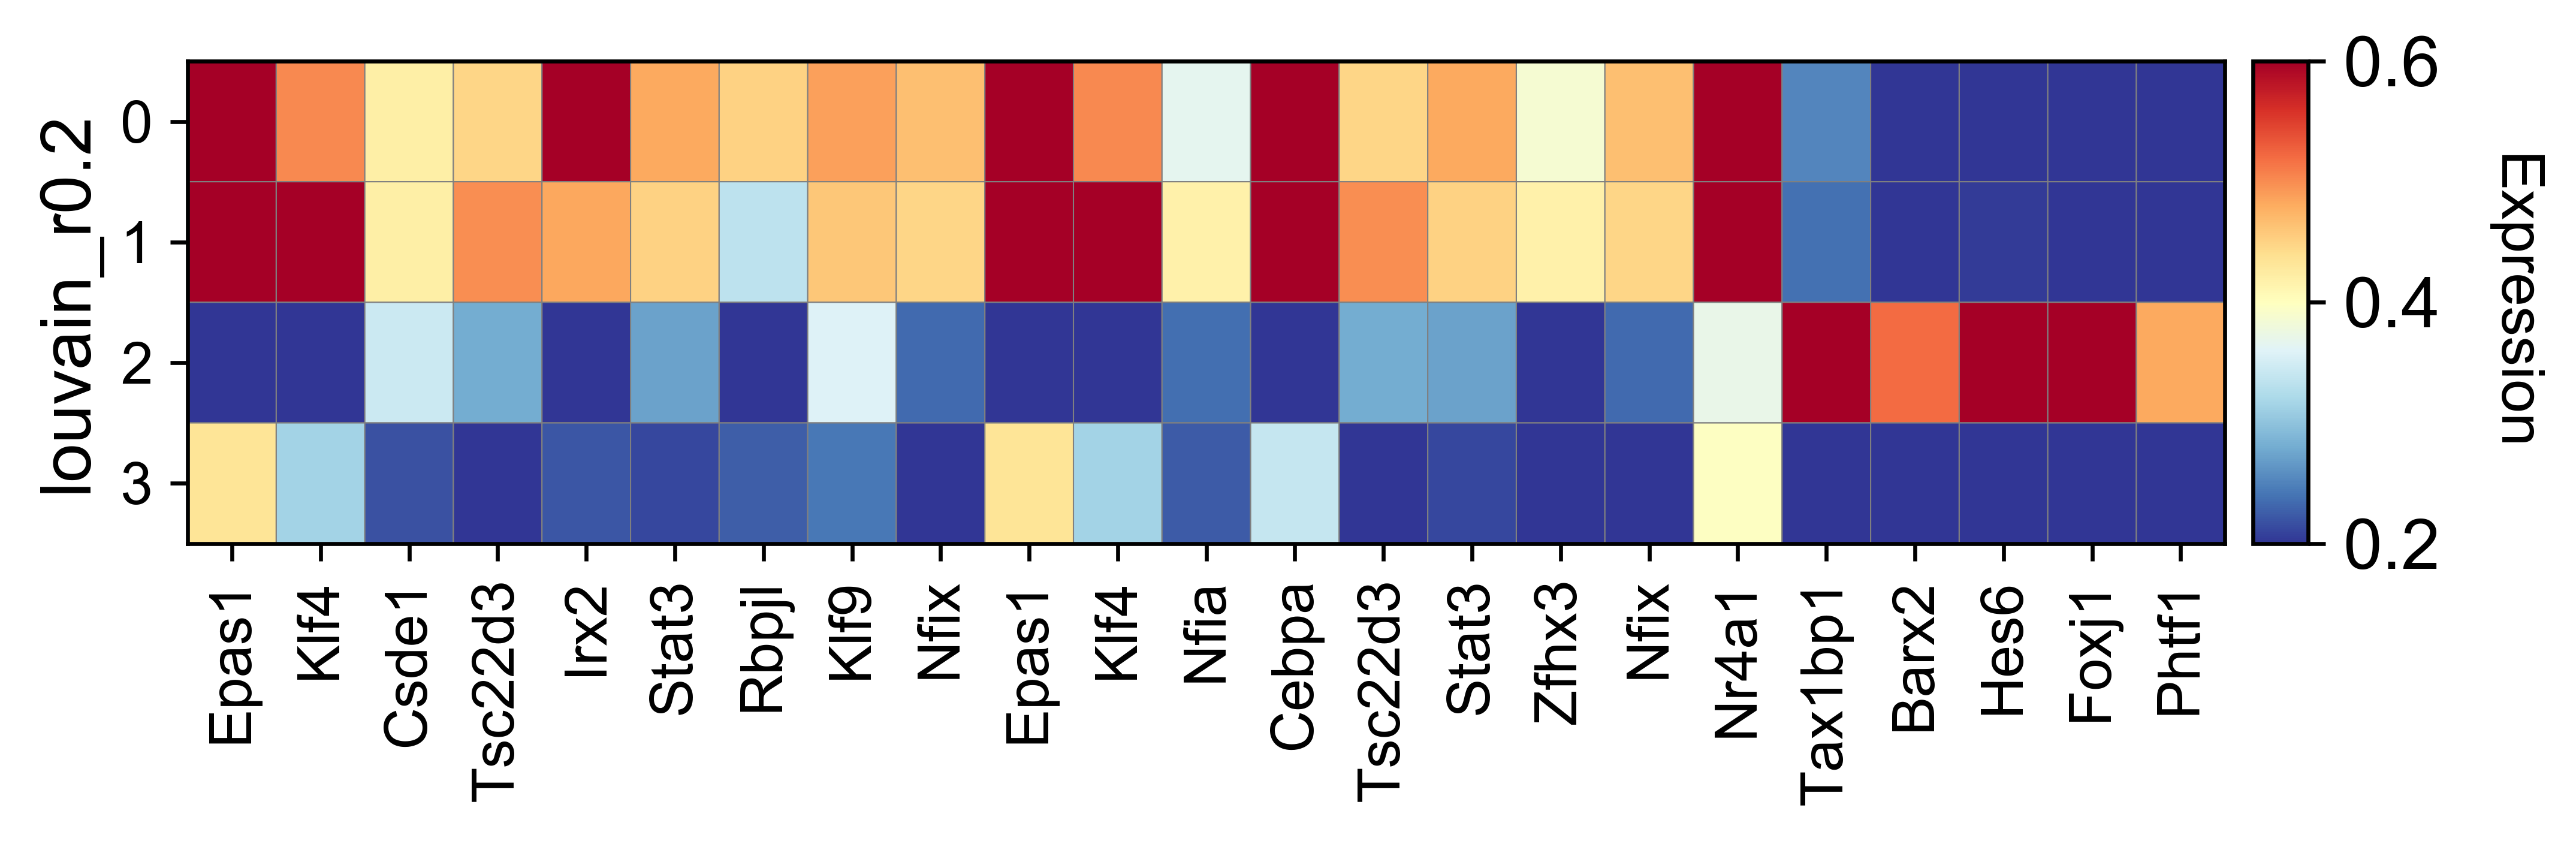

In [296]:
cmap2 = 'RdYlBu_r' # colormap

sc.pl.matrixplot(adata_subset, var_names=merged_tf, cmap=cmap2, groupby='louvain_r0.2', use_raw=False, 
swap_axes=False, vmin=0.2, vmax=0.6, dendrogram=False, show=False)
plt.ylabel('Expression',fontsize=12, rotation=270, labelpad=20)
plt.savefig('./figures/TF_TFC.png', bbox_inches='tight', dpi=300)

### Gene Ontology (GO) Enrichment Analysis - Biological Process

In [57]:
# Unfiltered gene list for GO analysis identification. I wanted to be less stringent here
sc.tl.rank_genes_groups(adata_subset, 'louvain_r0.2', method='wilcoxon',n_genes=1000, use_raw=True)

result = adata_subset.uns['rank_genes_groups']
groups = result['names'].dtype.names

# export DE results to excel 
mouse_DE_df=pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})
mouse_DE_df.to_excel("adata_subset_DE_top1000_unfiltered.xlsx", sheet_name='Top 1000 unfiltered')

# Look for enriched Gene Ontology Biological Process 2018 pathways

%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
import gseapy as gp
from gseapy.plot import barplot, dotplot # only needed if you want bar and dot plots

#view available reference libraries
names = gp.get_library_name() # a list of available libraries will appear

# turn columns into lists (filtered data)
C0 = mouse_DE_df['0_n']
C1 = mouse_DE_df['1_n']
C2 = mouse_DE_df['2_n']
C3 = mouse_DE_df['3_n']

# drop NaN: NaNs cause Enricher to break
C0=C0.dropna()
C1=C1.dropna()
C2=C2.dropna()
C3=C3.dropna()

# GO Analysis

Cluster0_GOBio = gp.enrichr(gene_list = C0,
description='Cluster0_GOBio',
gene_sets=['GO_Biological_Process_2018'],
outdir='Enricher_analysis/Cluster0_GOBio',
cutoff=0.05
)

Cluster1_GOBio = gp.enrichr(gene_list = C1,
description='Cluster1_GOBio',
gene_sets=['GO_Biological_Process_2018'],
outdir='Enricher_analysis/Cluster1_GOBio',
cutoff=0.05
)

Cluster2_GOBio = gp.enrichr(gene_list = C2,
description='Cluster2_GOBio',
gene_sets=['GO_Biological_Process_2018'],
outdir='Enricher_analysis/Cluster2_GOBio',
cutoff=0.05
)

Cluster3_GOBio = gp.enrichr(gene_list = C3,
description='Cluster3_GOBio',
gene_sets=['GO_Biological_Process_2018'],
outdir='Enricher_analysis/Cluster3_GOBio',
cutoff=0.05
)

# filter for statistically significant terms

c0_sig = Cluster0_GOBio.res2d.loc[(Cluster0_GOBio.res2d['Adjusted P-value'] < 0.05)] 
c1_sig = Cluster1_GOBio.res2d.loc[(Cluster1_GOBio.res2d['Adjusted P-value'] < 0.05)] 
c2_sig = Cluster2_GOBio.res2d.loc[(Cluster2_GOBio.res2d['Adjusted P-value'] < 0.05)] 
c3_sig = Cluster3_GOBio.res2d.loc[(Cluster3_GOBio.res2d['Adjusted P-value'] < 0.05)] 


c0_list = c0_sig['Term'].tolist() # at2 neg
c1_list = c1_sig['Term'].tolist() # at2 pos
c2_list = c2_sig['Term'].tolist() # ciliated
c3_list = c2_sig['Term'].tolist() # club

# look for unique and common terms in C1 and C0

c0_unique_terms = []
c1_unique_terms = []
common_terms = []

for i in c0_list:
    if i not in c1_list:
        c0_unique_terms.append(i)

for i in c1_list:
    if i not in c0_list:
        c1_unique_terms.append(i)
               
for i in c1_list:
    if i in c0_list:
        common_terms.append(i)   

ranking genes
    finished (0:00:12)


2019-12-05 22:42:32,336 Warning: No enrich terms using library GO_Biological_Process_2018 when cutoff = 0.05


In [58]:
# Export unique terms to excel
pd.DataFrame(c0_unique_terms).to_excel("Unique cluster 0 terms.xlsx", sheet_name='C0 unique')
pd.DataFrame(c1_unique_terms).to_excel("Unique cluster 1 terms.xlsx", sheet_name='C1 unique')
pd.DataFrame(common_terms).to_excel("Common cluster terms.xlsx", sheet_name='common') 

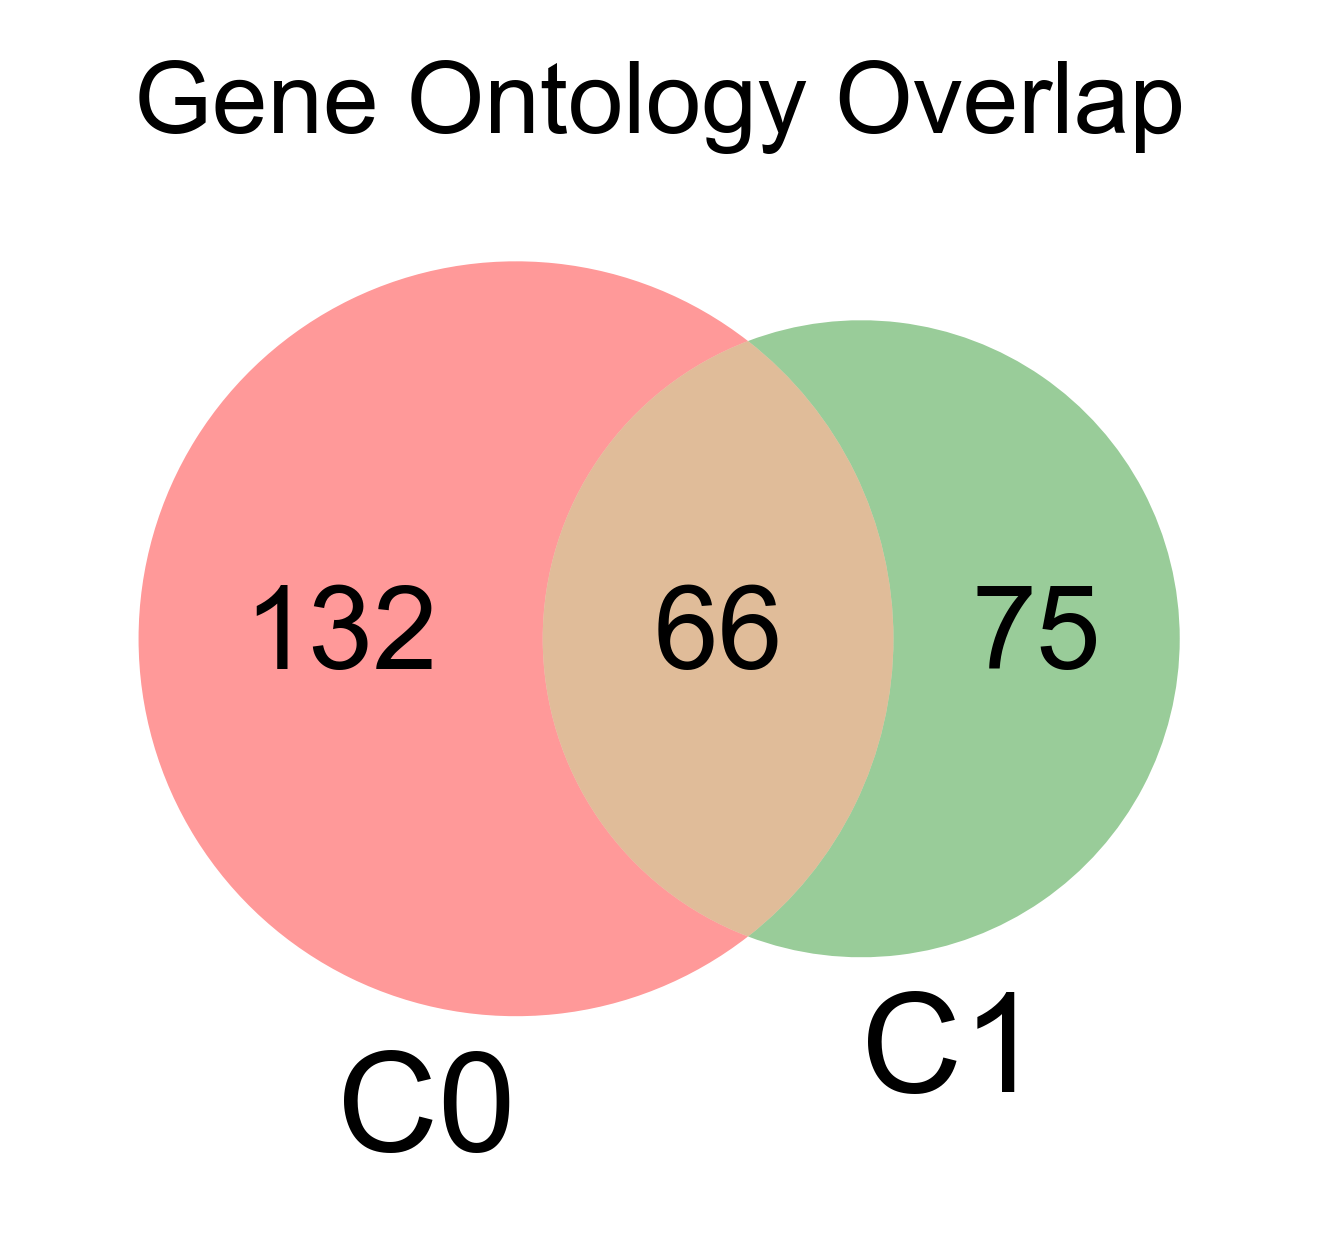

In [295]:
# Plot overlap using a venn diagram
from matplotlib_venn import venn2
ax=venn2([set(c0_list), set(c1_list)],set_labels = ('C0', 'C1'))
plt.title('Gene Ontology Overlap', fontsize=12)
plt.savefig('./figures/venn_GO_overlap.png', bbox_inches='tight', dpi=300)

## Plot gene signatures as a violin plot

### Subset Sftpc-HIGH clusters for comparison between YFP+ and YFP- clusters

In [ ]:
# make at2 subset
adata_at2 = adata_subset[adata_subset.obs['louvain_r0.2'].isin(['0','1'])]

#### Activation of Sox9 targets signature

In [163]:
# Calculate median
df=adata_at2.obs
df_1 = pd.pivot_table(df, values='Sox9_score', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0   -0.07429
1   -0.05499
dtype: float64

In [170]:
# Perform a Mann Whitney U test for AT2 signature
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat0['Sox9_score'], cat1['Sox9_score']) # statistic=1289240.0, pvalue=0.0

MannwhitneyuResult(statistic=4310014.0, pvalue=5.660818635877128e-07)

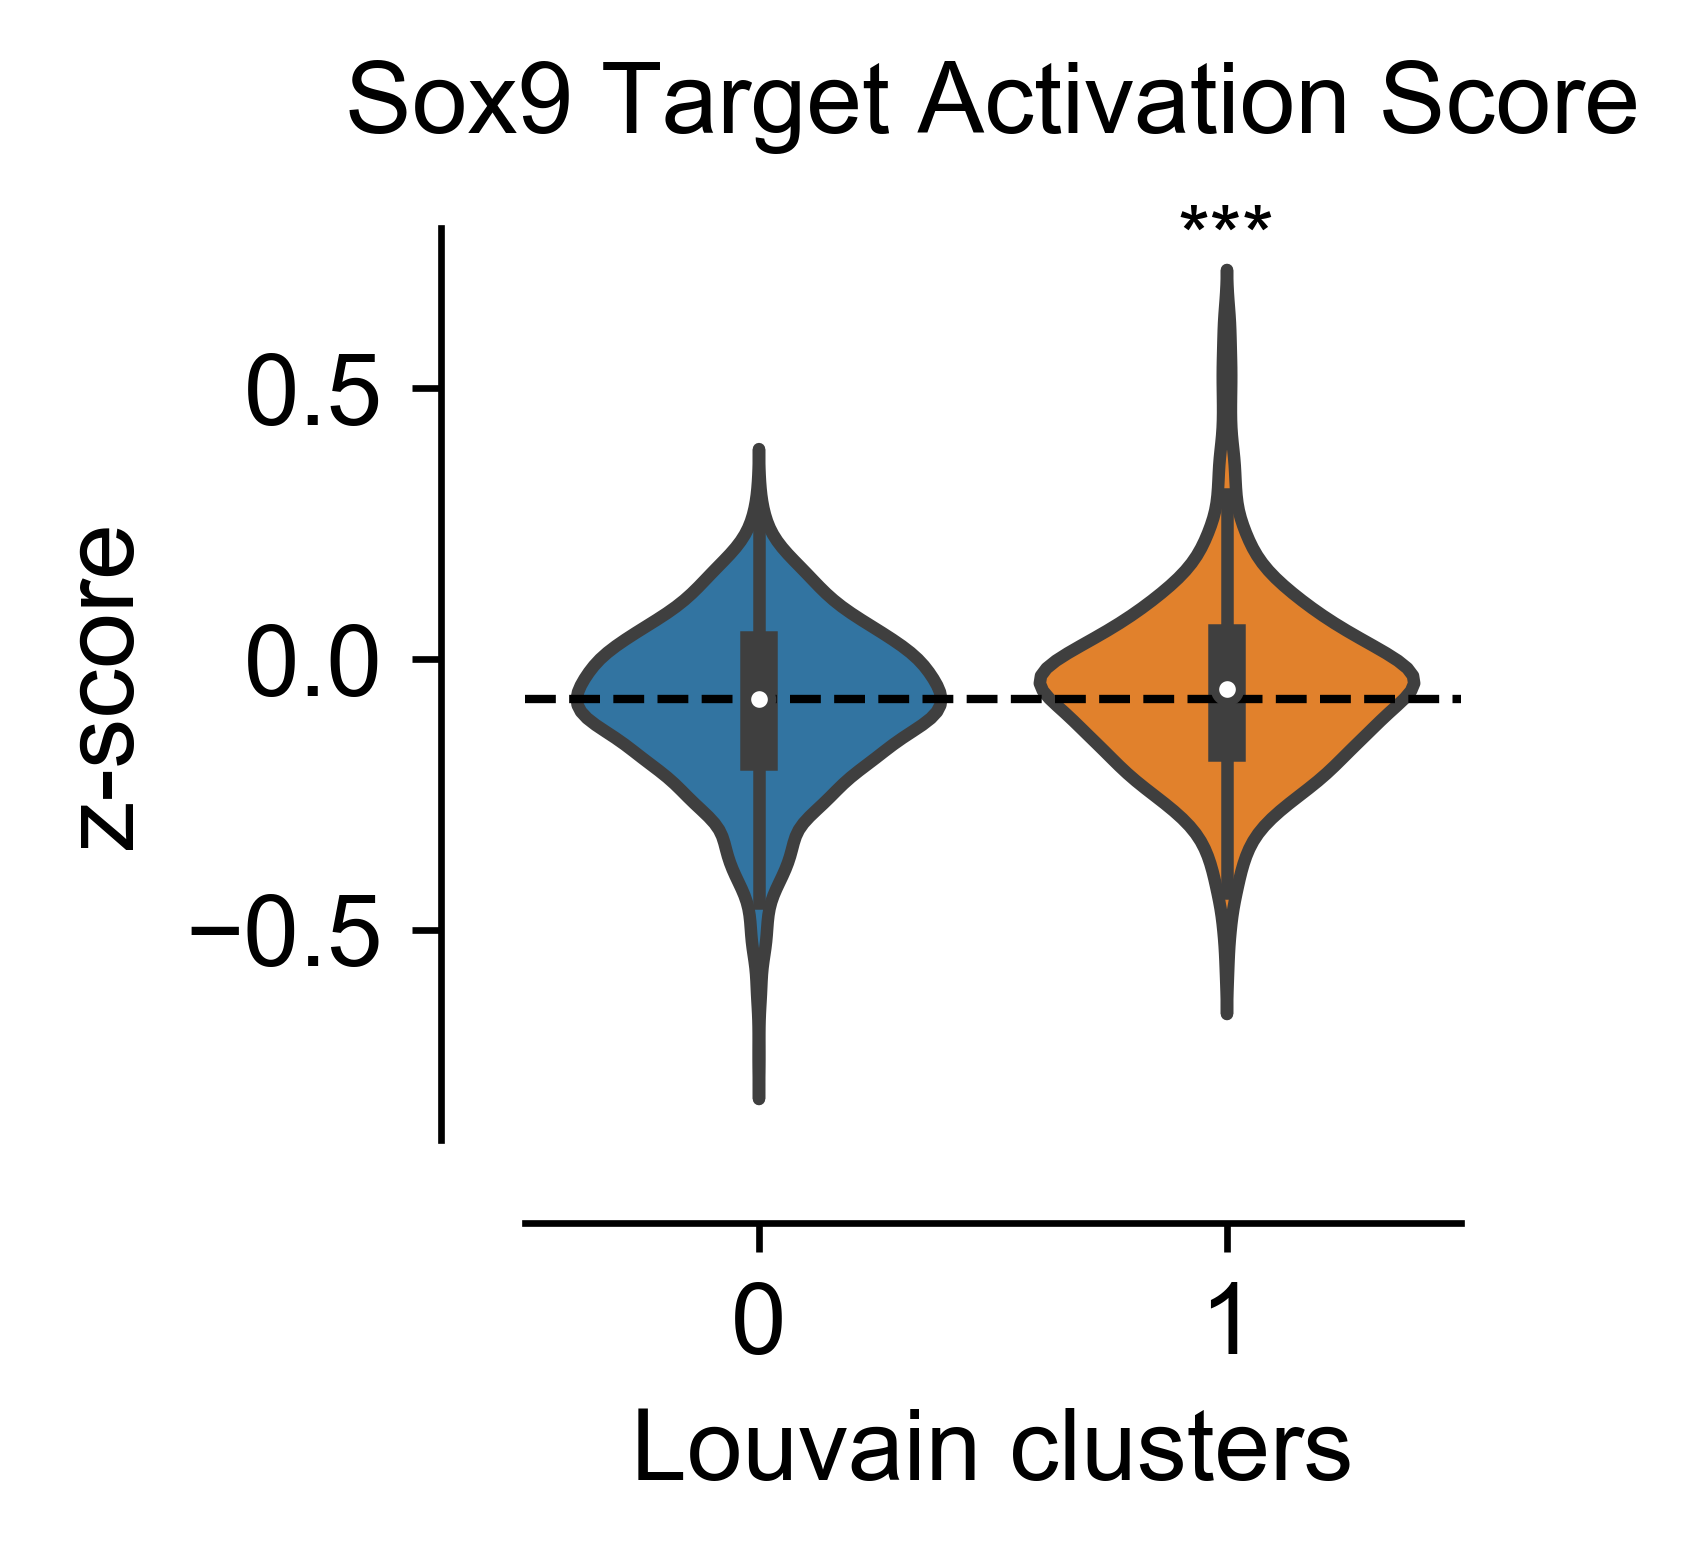

In [251]:
# Plot results
rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi']=300
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Sox9_score', x='louvain_r0.2', data=adata_subset.obs, order=['0','1'])
despine(right=True, offset=10)
plt.title('Sox9 Target Activation Score', fontsize=12, y=1.05)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(-0.07429, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Sox9_score'].max() + 0.7, 0.7, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

plt.savefig('./figures/sox9_score.png', bbox_inches="tight")

#### AT2 signature

In [64]:
# Calculate median
df=adata_at2.obs
df_1 = pd.pivot_table(df, values='AT2 signature', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    0.480113
1    0.296587
dtype: float64

In [67]:
# Perform a Mann Whitney U test for AT2 signature
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat0['AT2 signature'], cat1['AT2 signature']) # statistic=1289240.0, pvalue=0.0

MannwhitneyuResult(statistic=1052806.0, pvalue=0.0)

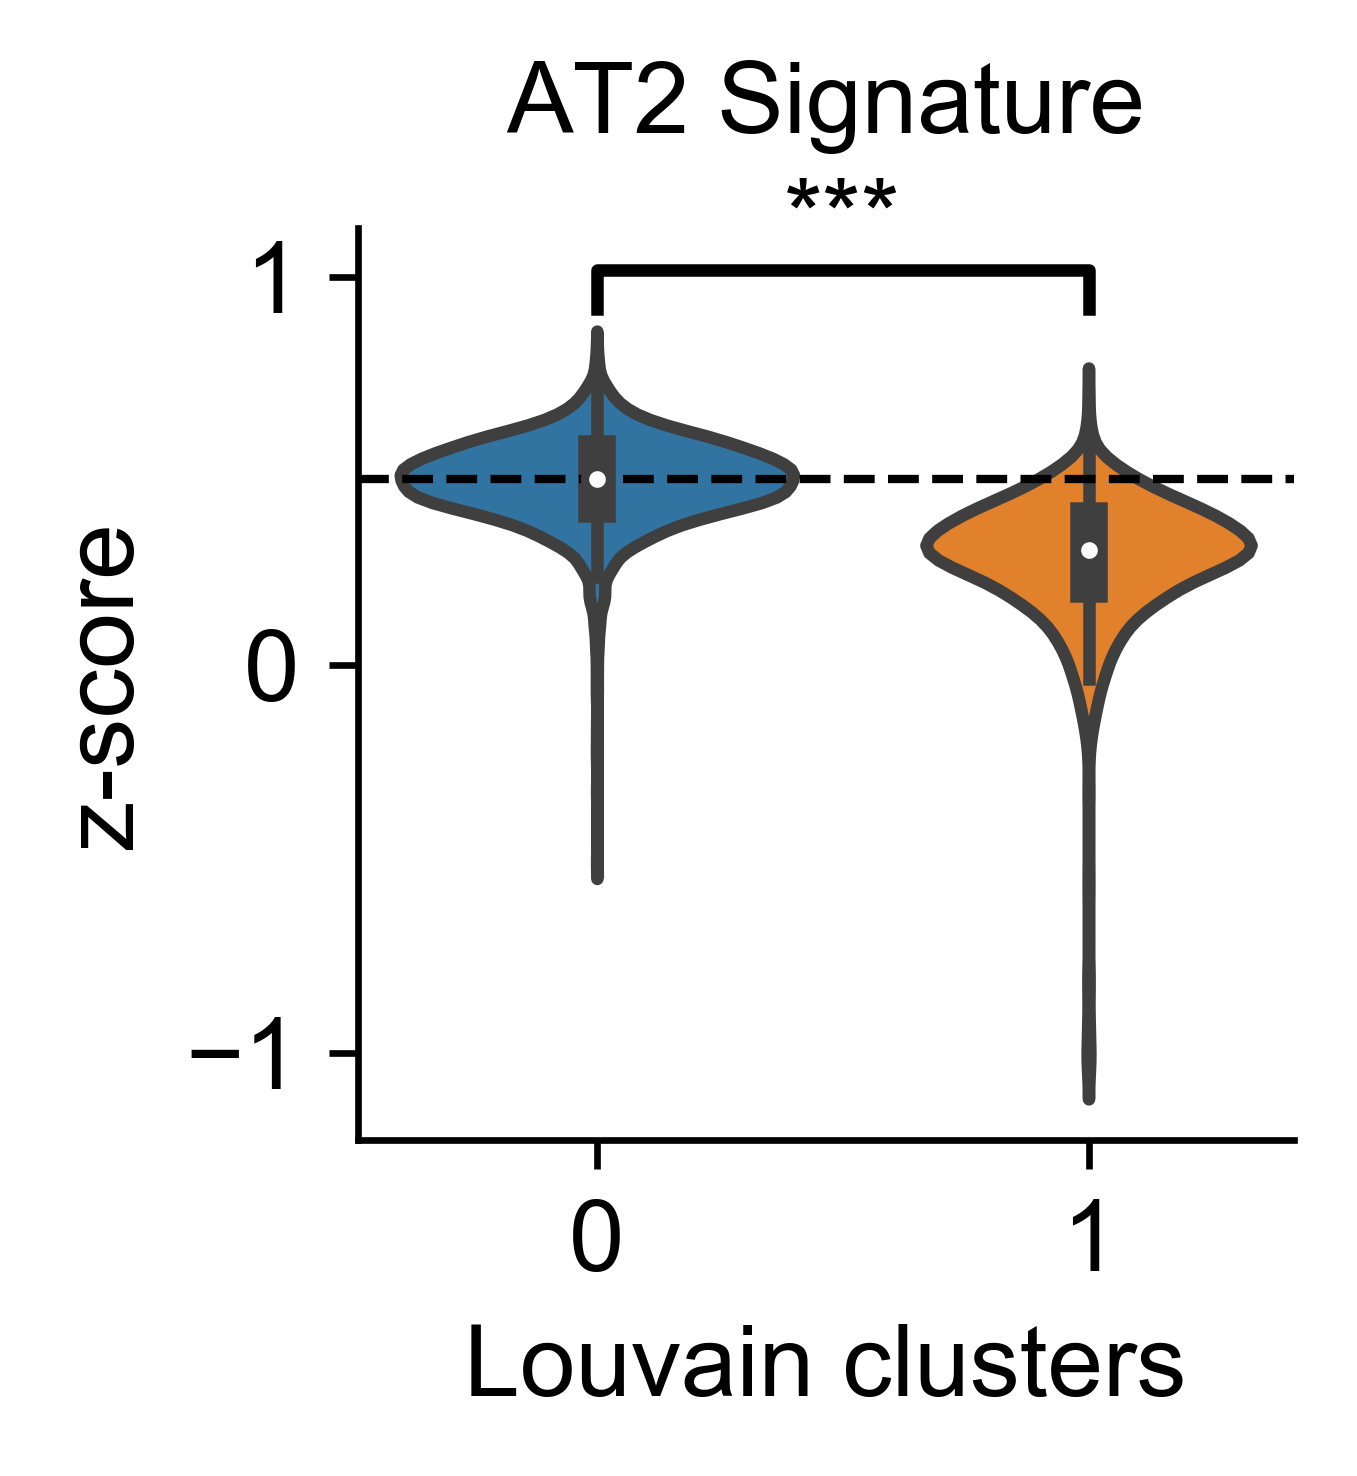

In [95]:
# Plot AT2 signatures as boxplots

# Plot results
rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi']=300
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='AT2 signature', x='louvain_r0.2', data=adata_subset.obs, order=['0','1'])
despine(right=True)
plt.title('AT2 Signature', fontsize=12, y=1.05)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(0.480113, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = adata_subset.obs['AT2 signature'].max() + 0.1, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/AT2_signature.png', bbox_inches="tight")

#### Hmag2 and Nkx2-1 expression

In [74]:
# add expression information to adata_at2.obs
adata_at2.obs['Nkx2-1']=adata_at2[:, ['Nkx2-1']].to_df()
adata_at2.obs['Hmga2']=adata_at2[:, ['Hmga2']].to_df()

# Perform a Mann Whitney U test for AT2 signature
cat0 = adata_at2.obs[(adata_at2.obs['louvain_r0.2'] == '0')]
cat1 = adata_at2.obs[(adata_at2.obs['louvain_r0.2'] == '1')]

Trying to set attribute `.obs` of view, making a copy.


In [79]:
# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat0['Hmga2'], cat1['Hmga2']) # statistic=4782711.0, pvalue=0.45528173093750657
mannwhitneyu(cat0['Nkx2-1'], cat1['Nkx2-1']) # statistic=1677465.5, pvalue=0.0

MannwhitneyuResult(statistic=3889345.0, pvalue=2.622990917673745e-28)

In [75]:
# Find median C0 values for Nkx2-1 and Hmga2
df=adata_at2.obs
df_1 = pd.pivot_table(df, values='Nkx2-1', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    0.927835
1    0.830995
dtype: float32

In [77]:
# Find median C0 values for Nkx2-1 and Hmga2
df=adata_at2.obs
df_1 = pd.pivot_table(df, values='Hmga2', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.05
0    0.000211
1    0.000540
dtype: float32

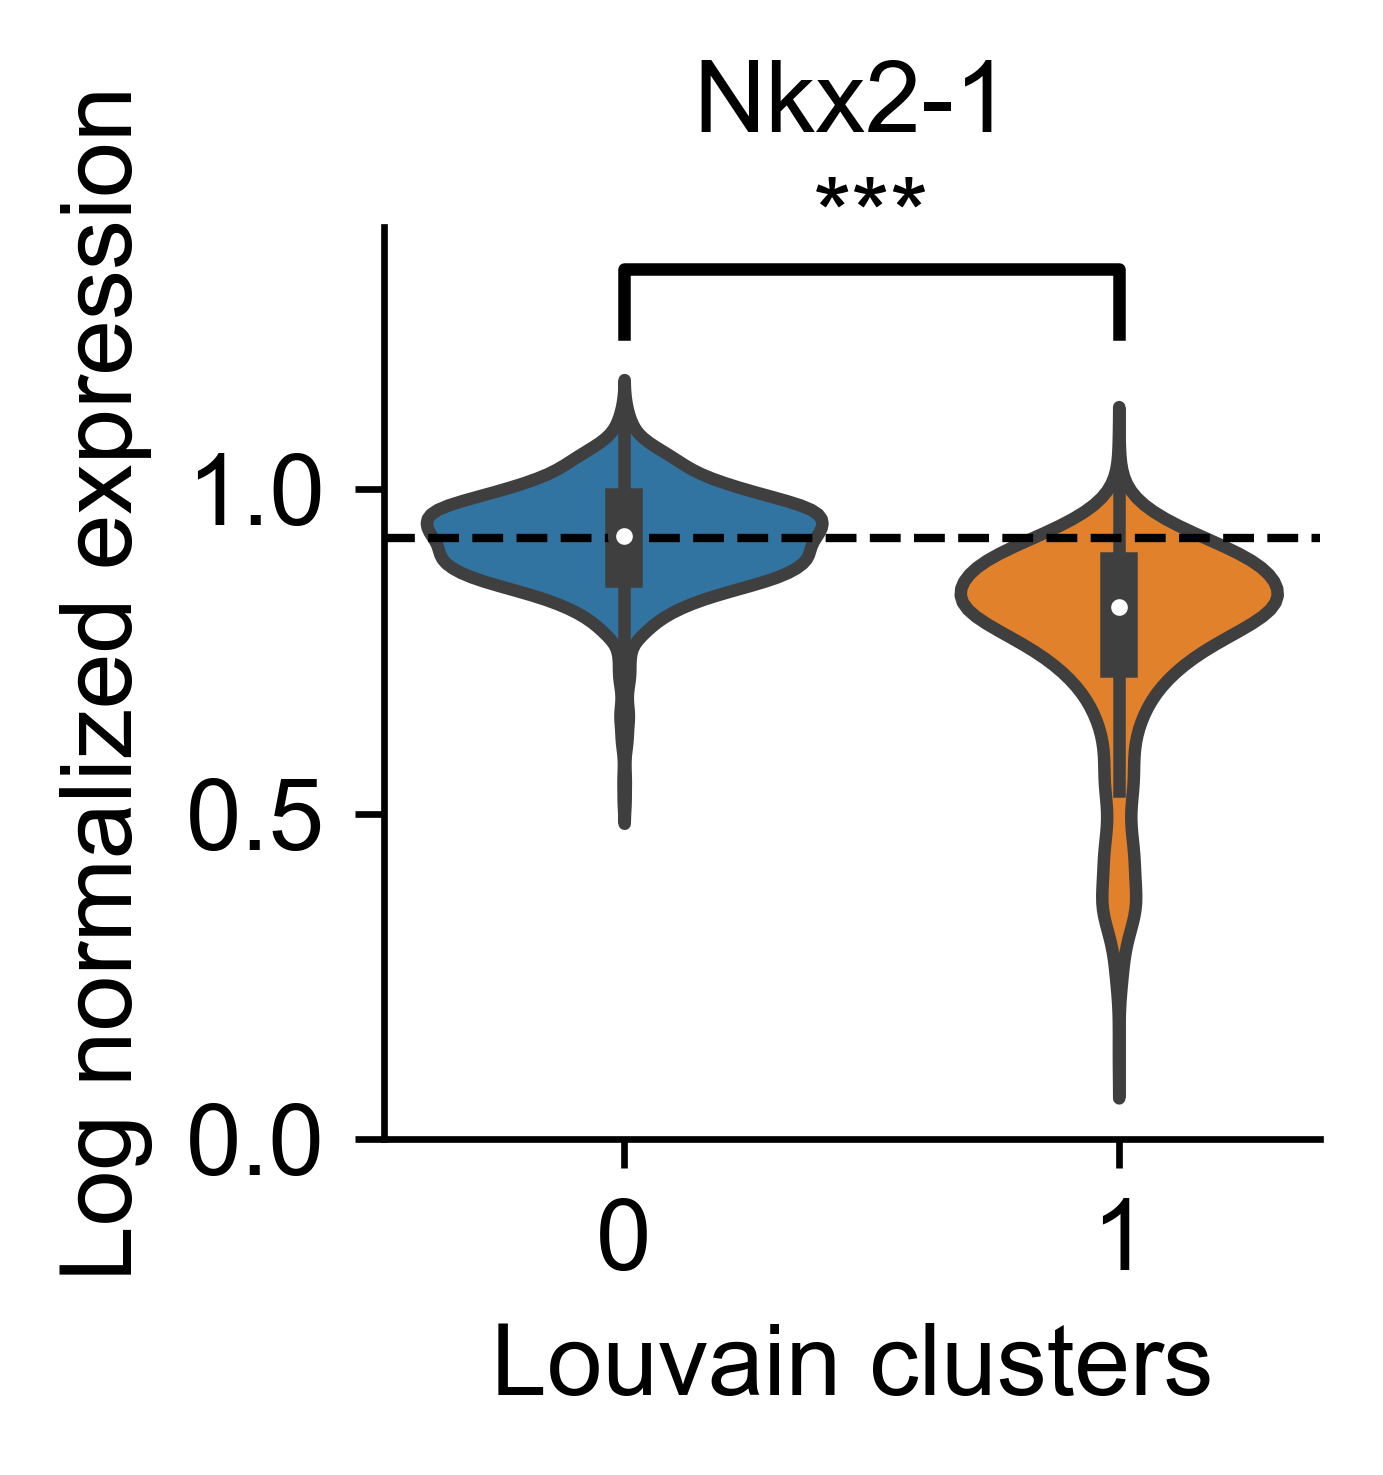

In [94]:
# Plot Nkx2-1 expression

# Plot results
rcParams['figure.figsize'] = 2,2
rcParams['figure.dpi'] = 300
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Nkx2-1', x='louvain_r0.2', data=adata_at2.obs, order=['0','1'])
despine(right=True)
plt.title('Nkx2-1', fontsize=12, y=1.05)
plt.ylabel('Log normalized expression', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(0.924642, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1, x2 = 0, 1 
y, h, col = adata_subset.obs['Nkx2-1'].max() + 0.1, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/Nkx2-1_expression.png', bbox_inches="tight")

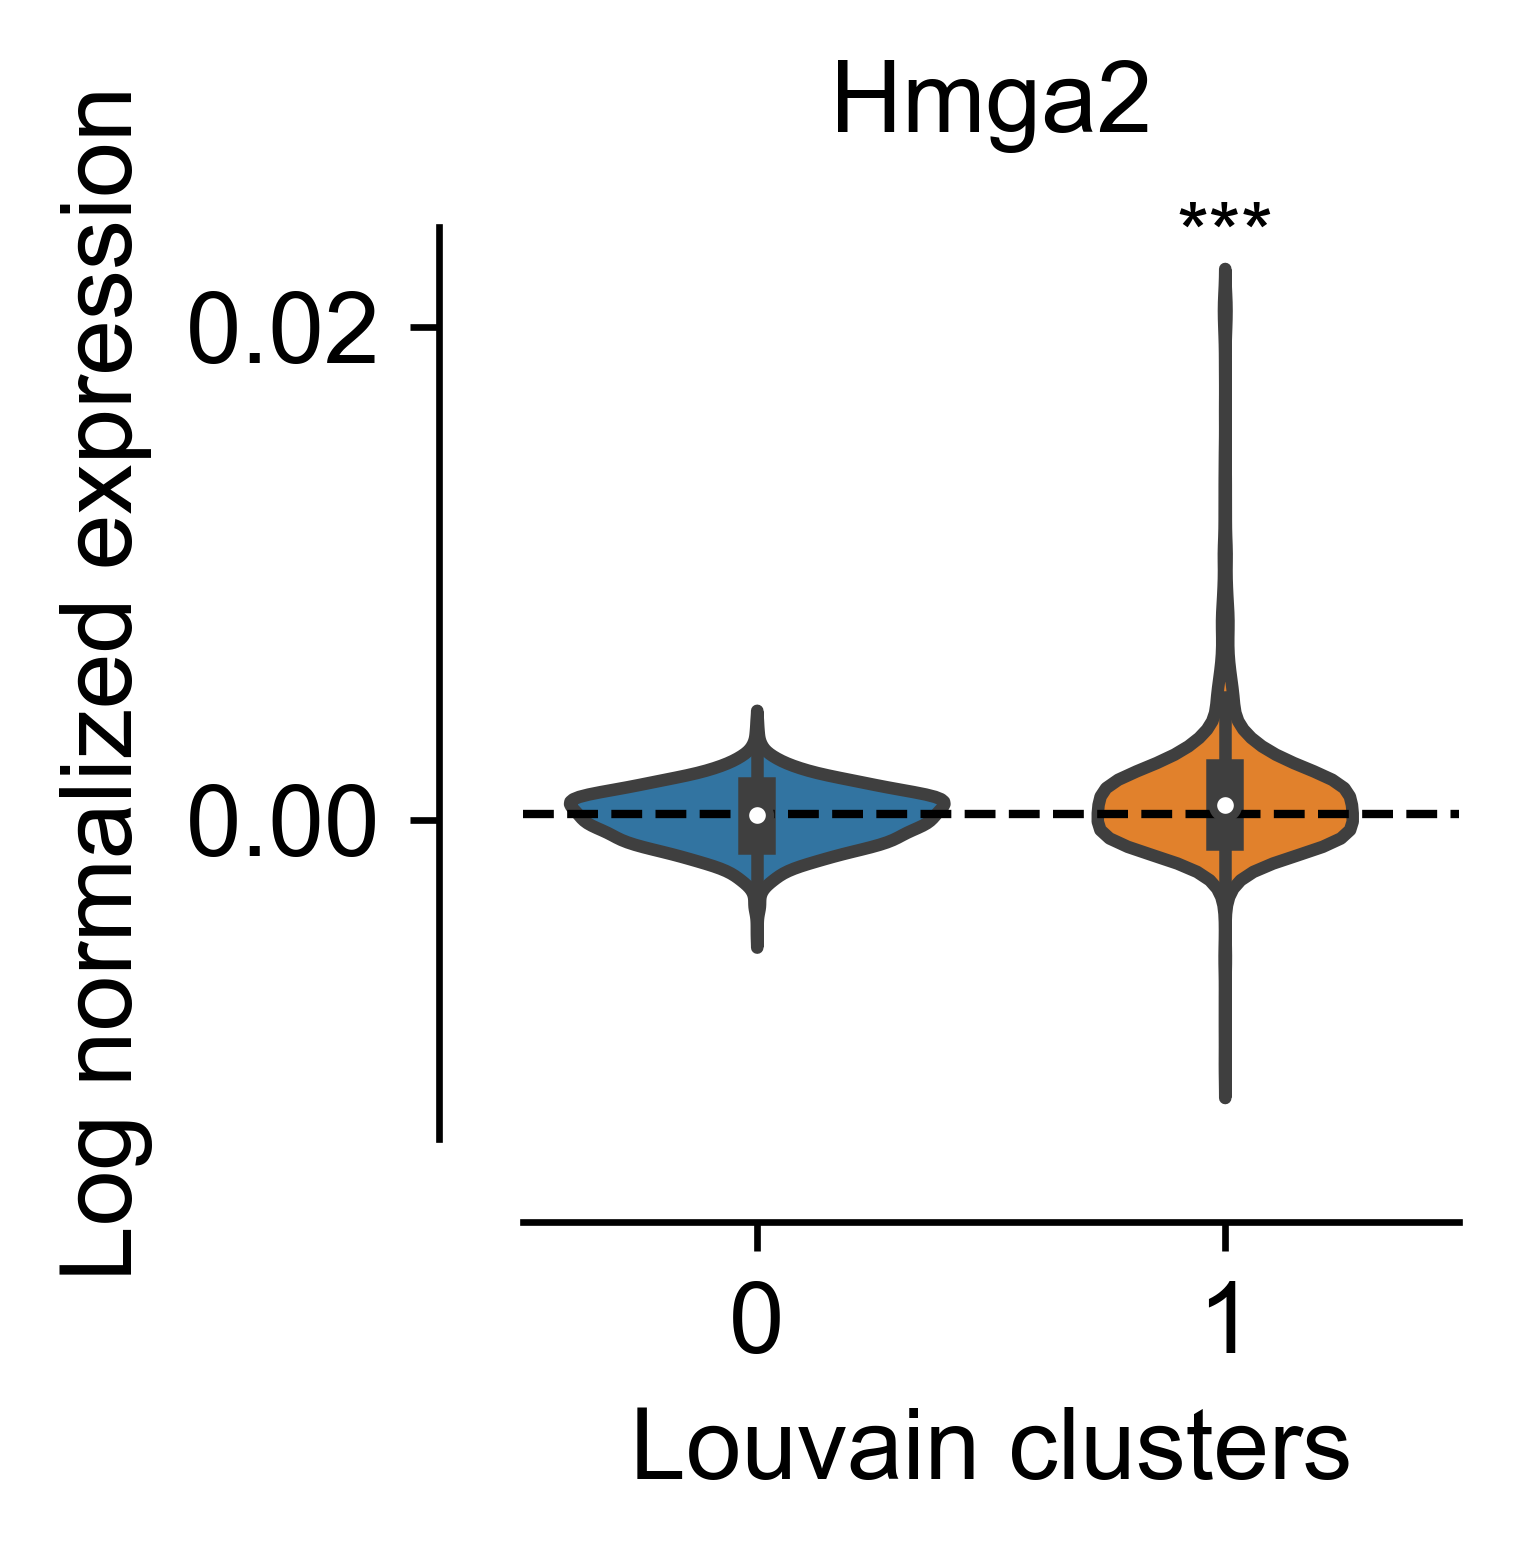

In [254]:
# Plot Hmga2 expression

# Plot results
rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Hmga2', x='louvain_r0.05', data=adata_at2.obs, order=['0','1'])
despine(right=True, offset=10)
plt.title('Hmga2', fontsize=12, y=1.05)
plt.ylabel('Log normalized expression', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(0.000211, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_subset.obs['Hmga2'].max() + 0.022, 0.022, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

plt.savefig('./figures/Hmga2_expression.png', bbox_inches="tight", dpi=300)

#### Ly6a

In [234]:
adata_at2.obs['Ly6a']=adata_at2[:, ['Ly6a']].to_df() # add Ly6a expression info to adata_at2.obs

# find median
df=adata_at2.obs
df_1 = pd.pivot_table(df, values='Ly6a', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    0.060106
1    0.220388
dtype: float32

In [231]:
# Perform a Mann Whitney U test 
cat0 = adata_at2.obs[(adata_at2.obs['louvain_r0.2'] == '0')]
cat1 = adata_at2.obs[(adata_at2.obs['louvain_r0.2'] == '1')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat0['Ly6a'], cat1['Ly6a']) # significant

MannwhitneyuResult(statistic=855018.0, pvalue=0.0)

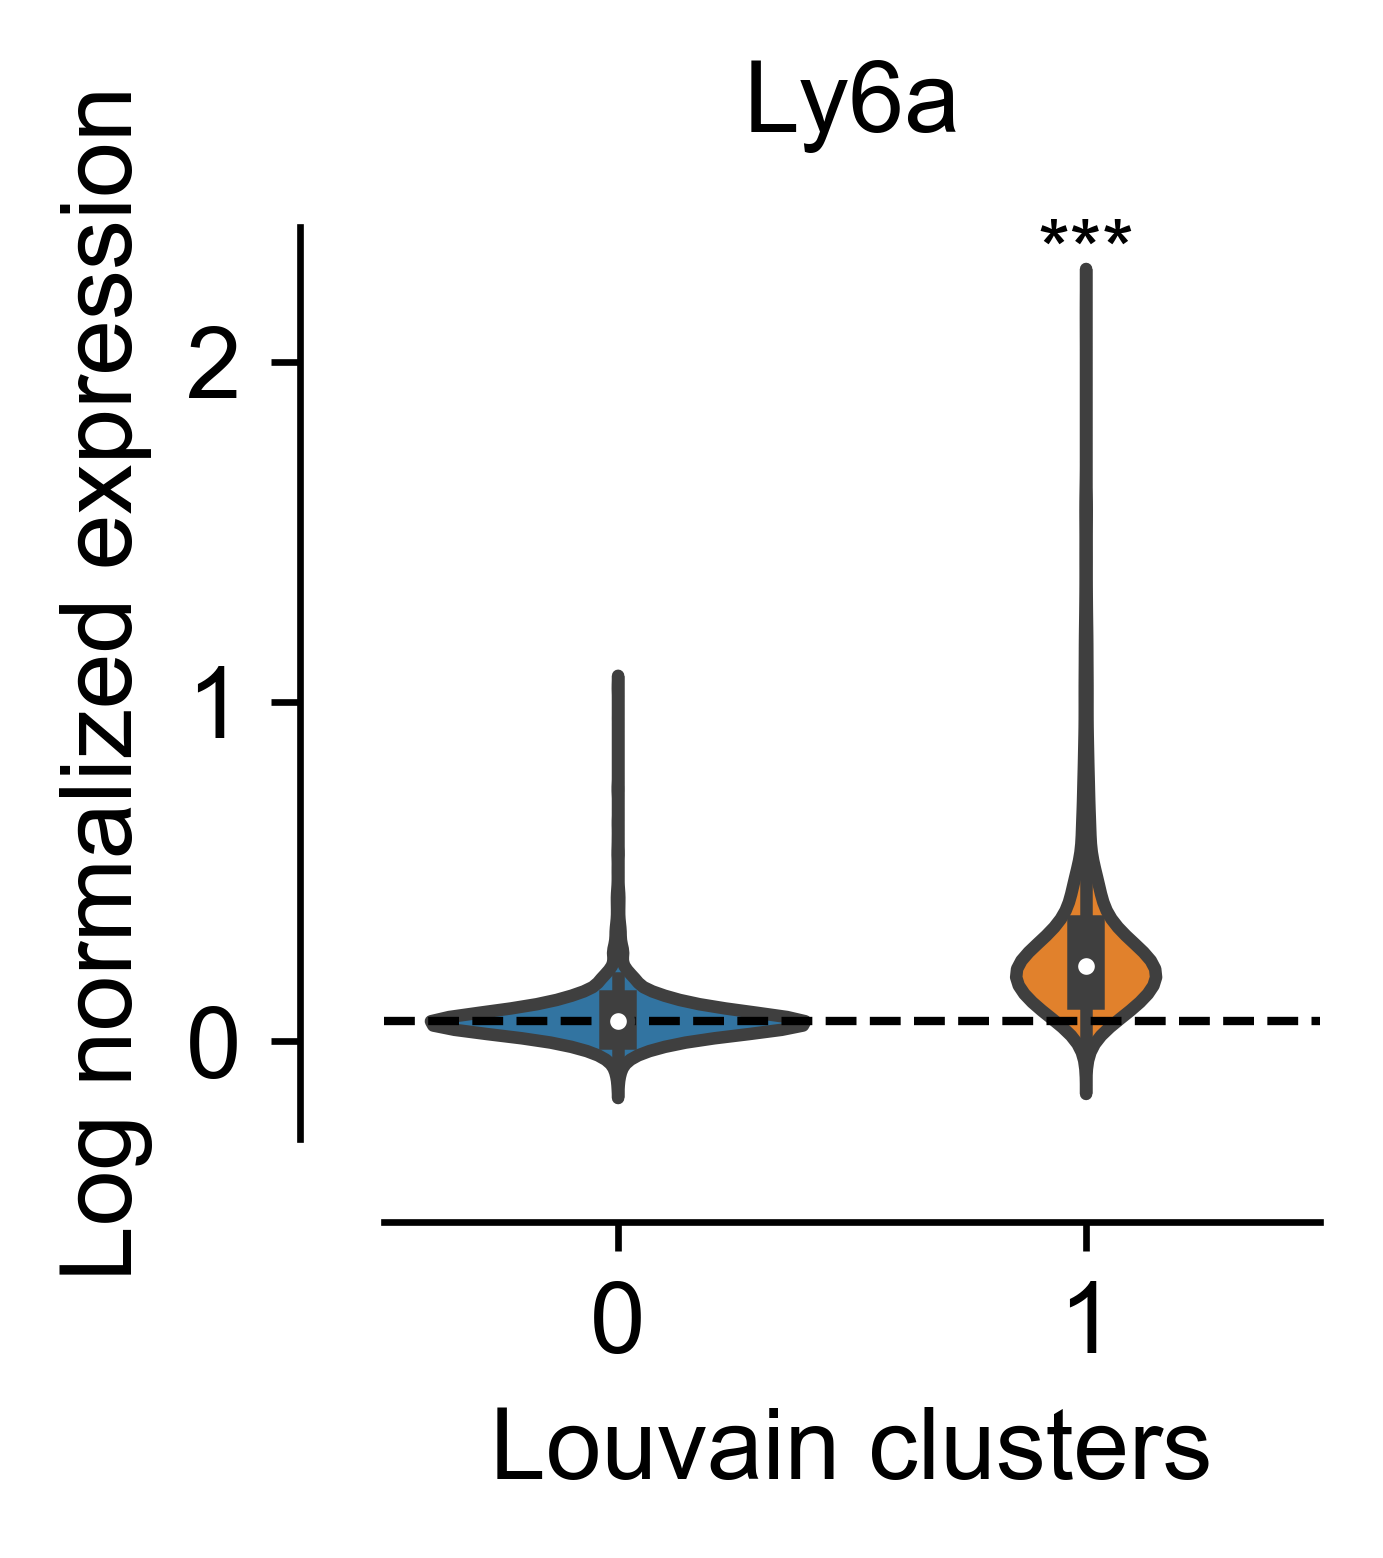

In [253]:
# Plot Ly6a expression

# Plot results
rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Ly6a', x='louvain_r0.2', data=adata_at2.obs, order=['0','1'])
despine(right=True, offset=10)
plt.title('Ly6a', fontsize=12, y=1.05)
plt.ylabel('Log normalized expression', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(0.060106, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_at2.obs['Ly6a'].max() + 2.2, 2.2, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

plt.savefig('./figures/Ly6a_expression.png', bbox_inches="tight", dpi=300)

## Sox9

In [238]:
adata_at2.obs['Sox9']=adata_at2[:, ['Sox9']].to_df()
df=adata_at2.obs
df_1 = pd.pivot_table(df, values='Sox9', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0    0.000019
1    0.000257
dtype: float32

In [239]:
# Perform a Mann Whitney U test 
cat0 = adata_at2.obs[(adata_at2.obs['louvain_r0.2'] == '0')]
cat1 = adata_at2.obs[(adata_at2.obs['louvain_r0.2'] == '1')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat0['Sox9'], cat1['Sox9']) # significant

MannwhitneyuResult(statistic=3997716.0, pvalue=2.7583412307601287e-21)

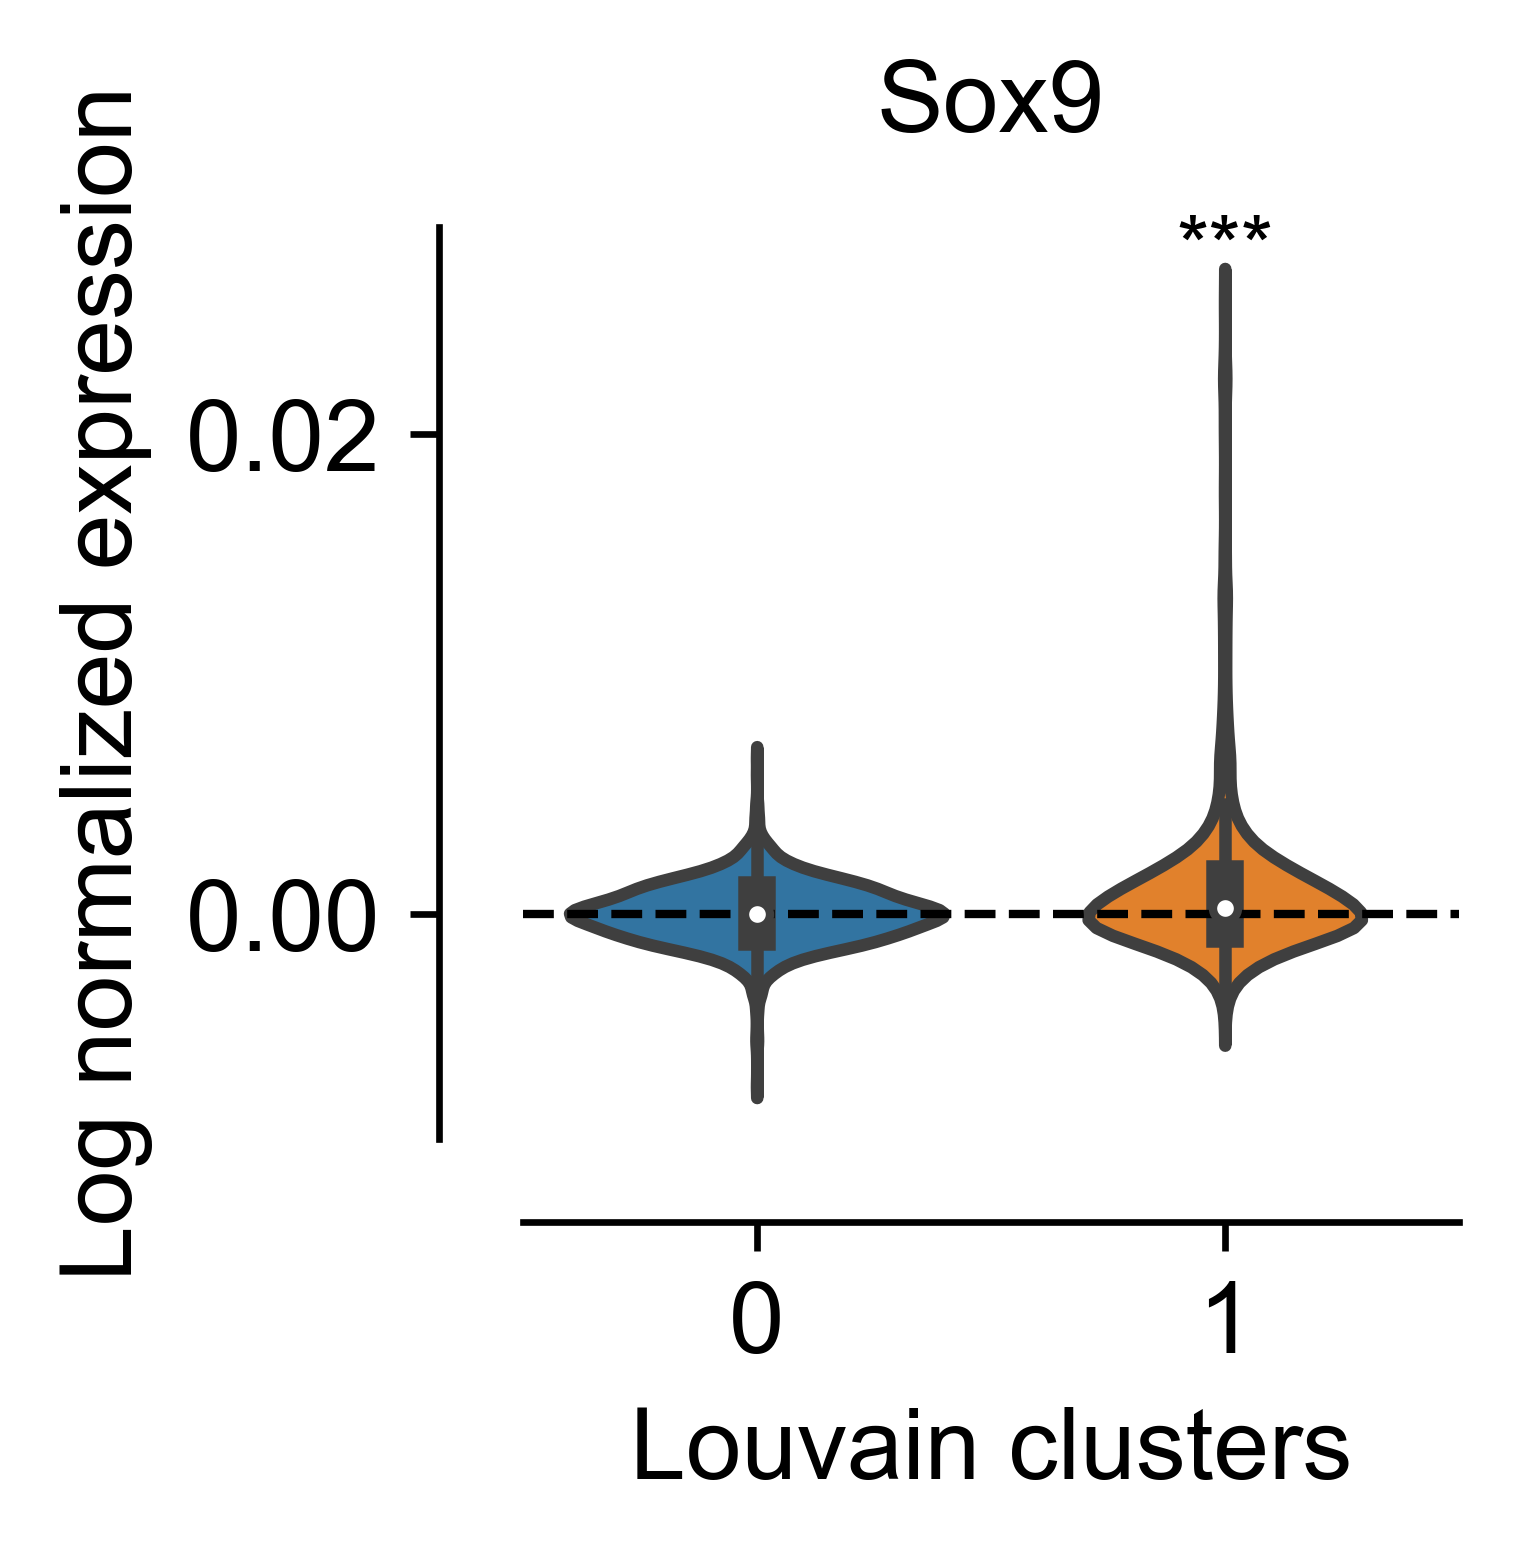

In [252]:
# Plot results
rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Sox9', x='louvain_r0.2', data=adata_at2.obs, order=['0','1'])
despine(right=True, offset=10)
plt.title('Sox9', fontsize=12, y=1.05)
plt.ylabel('Log normalized expression', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(0.000019, color='black', linestyle='dashed', linewidth = 1) 

# statistical annotation
x1 = 1  
y, h, col = adata_at2.obs['Sox9'].max() + 0.026, 0.026, 'k'
plt.text(x1, h, "***", ha='center', va='bottom', color=col, fontsize=10)

plt.savefig('./figures/Sox9_expression.png', bbox_inches="tight", dpi=300)

## Kras activation signature

In [88]:
df=adata_at2.obs
df_1 = pd.pivot_table(df, values='Kras activation signature', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0   -0.116941
1    0.216456
dtype: float64

In [96]:
# Perform a Mann Whitney U test for AT2 signature
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat0['Kras activation signature'], cat1['Kras activation signature']) 

MannwhitneyuResult(statistic=2107915.0, pvalue=4.207878988802592e-297)

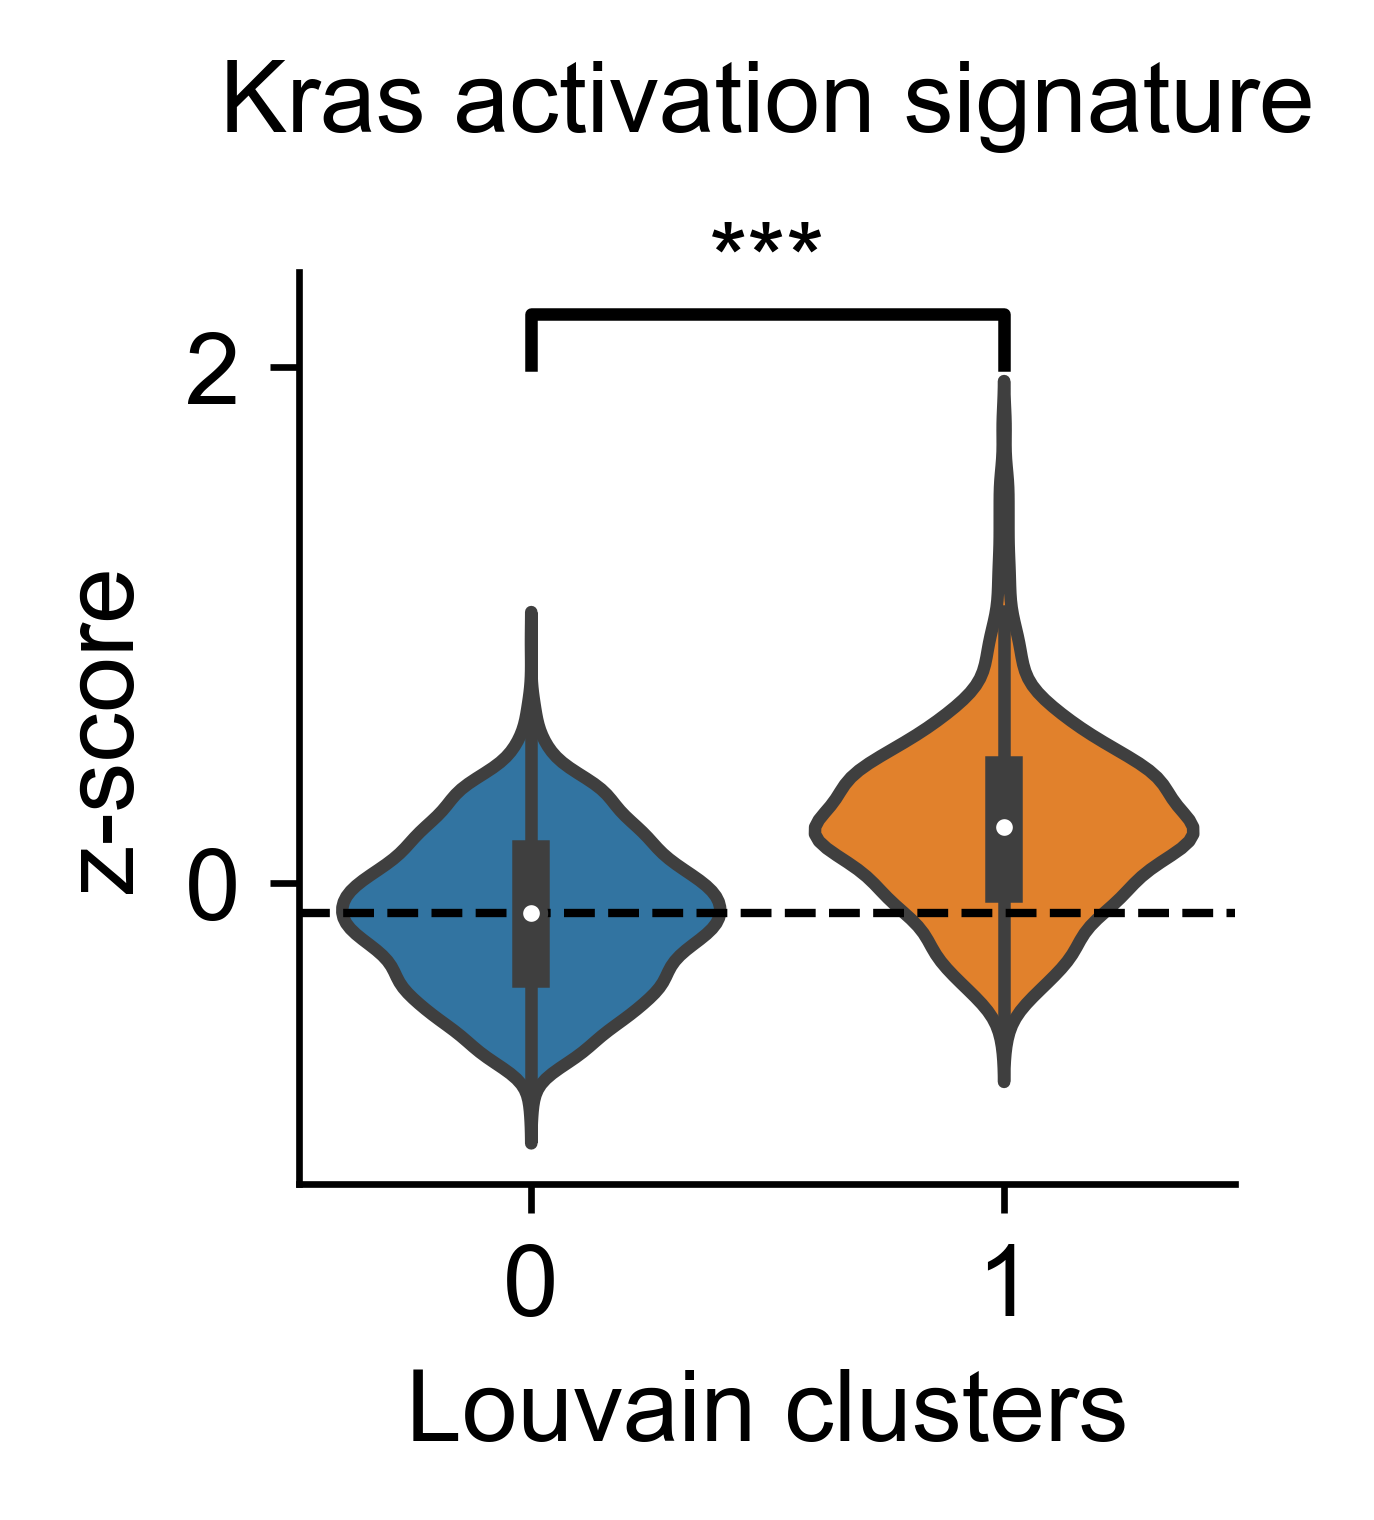

In [125]:
# Plot results
rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Kras activation signature', x='louvain_r0.2', data=adata_at2.obs)
despine(right=True)
plt.title('Kras activation signature', fontsize=12, y=1.1)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(-0.116941, color='black', linestyle='dashed', linewidth = 1)

# statistical annotation
x1, x2 = 0, 1  
y, h, col = adata_at2.obs['Kras activation signature'].max() + 0.2, 0.2, 'k' # bar location
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/kras_signature_expression.png', bbox_inches="tight")

## Kras all clusters

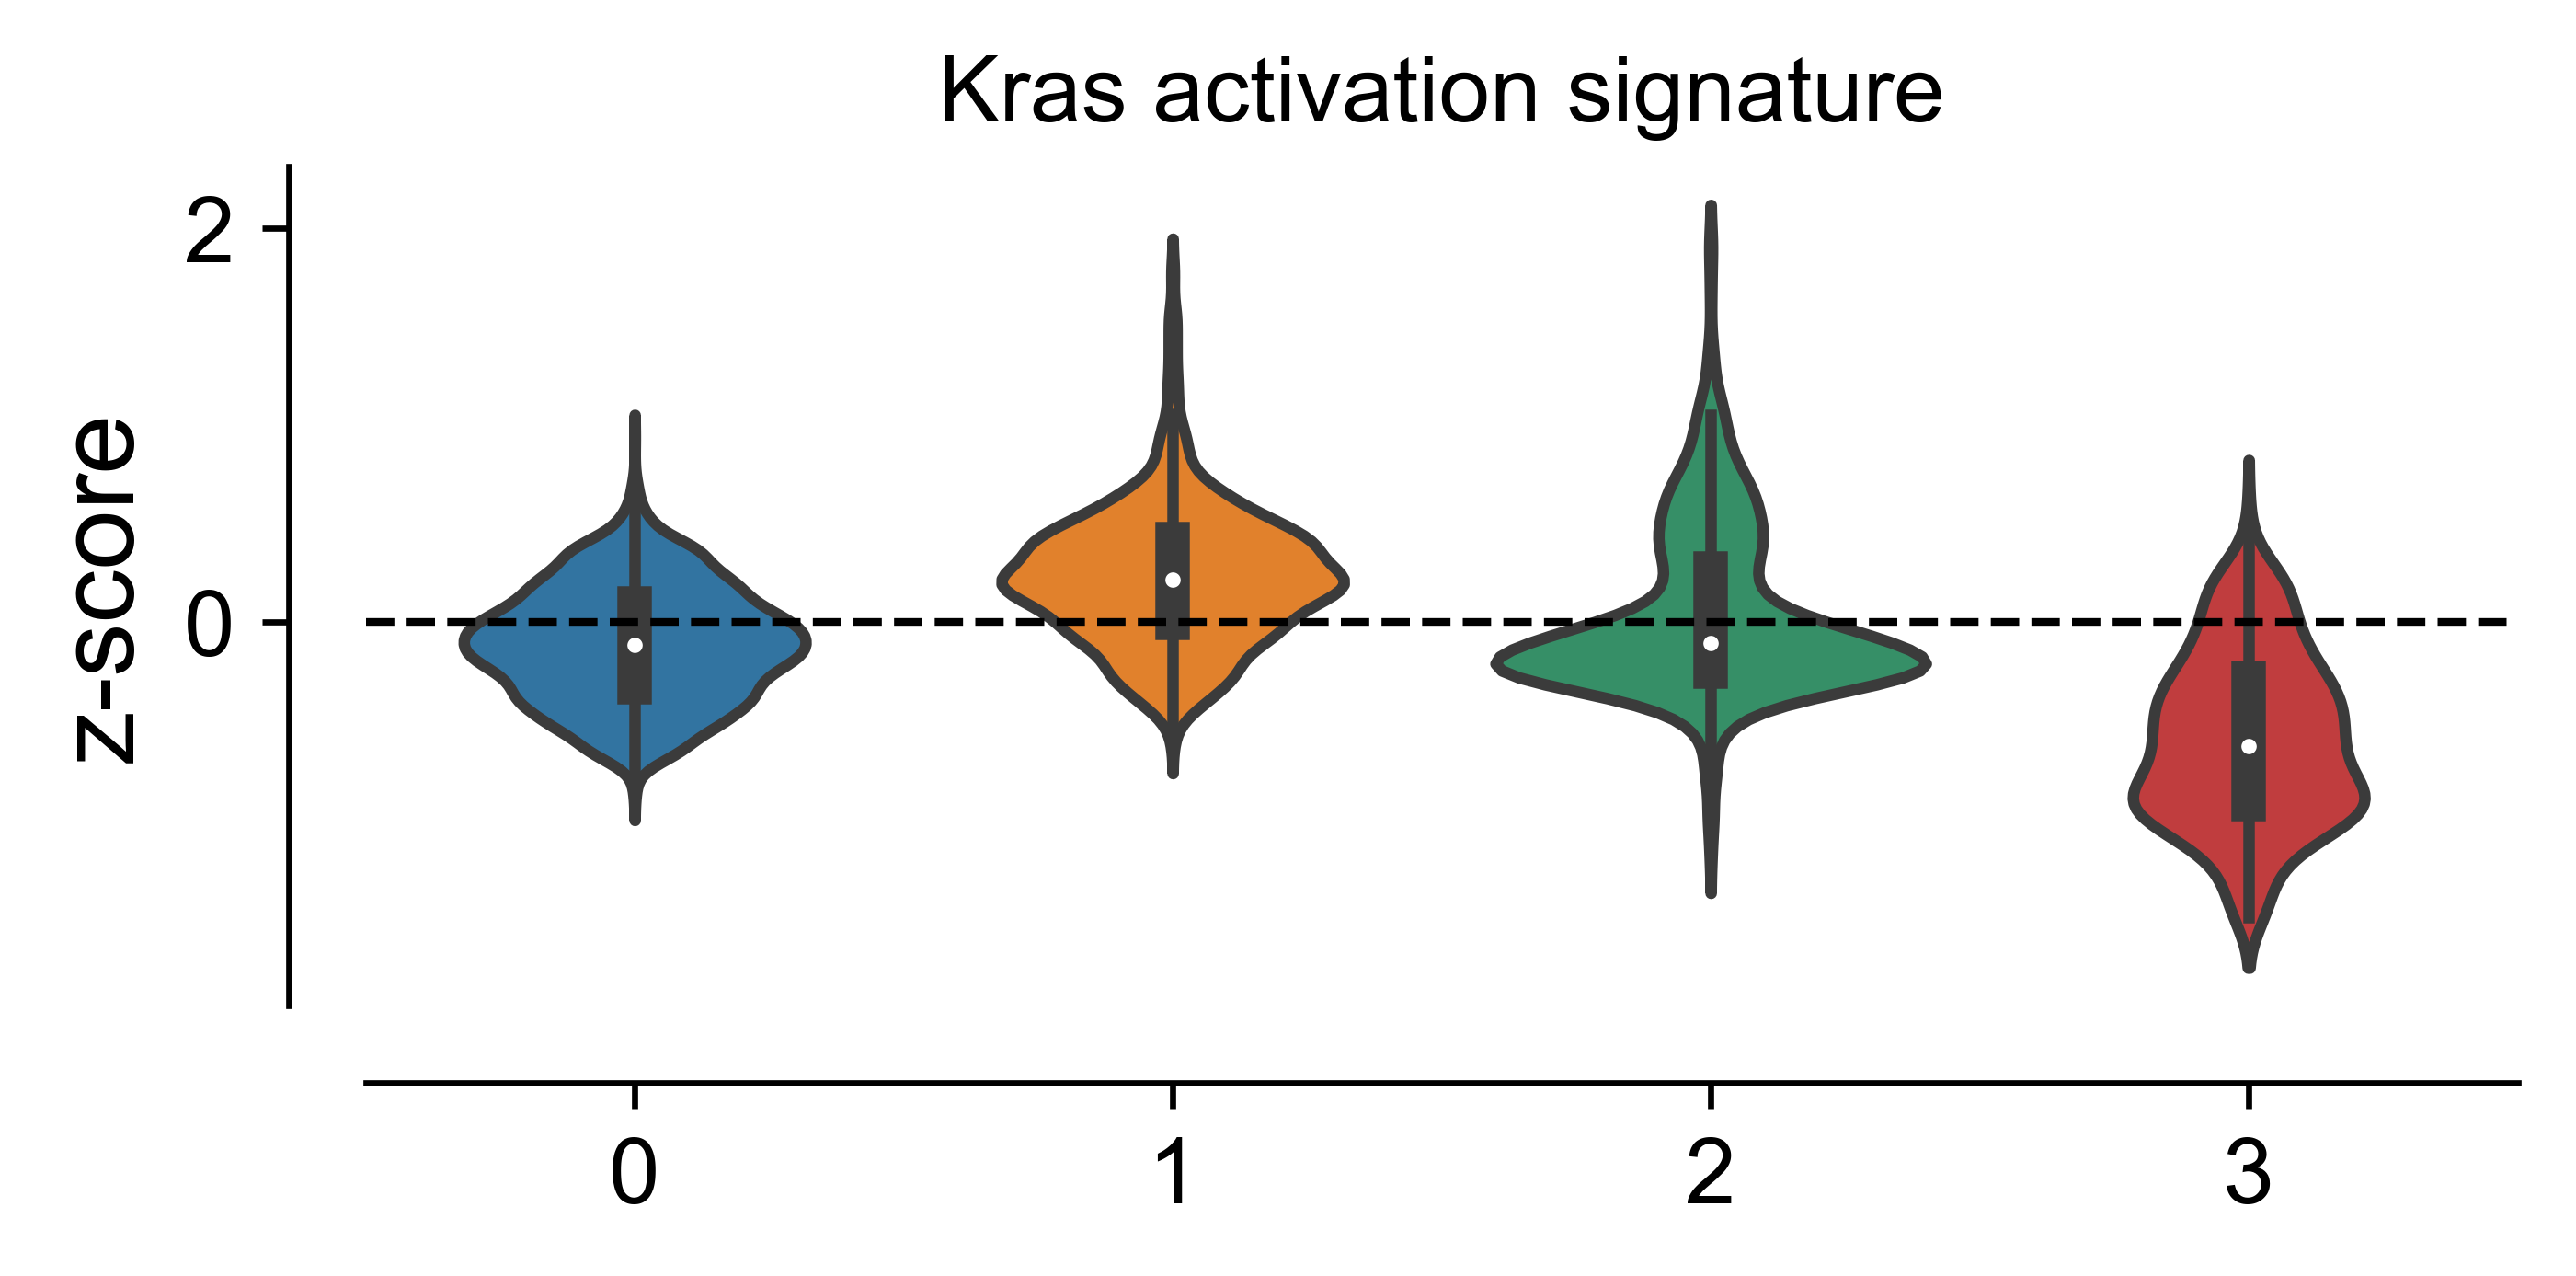

In [281]:
# Plot results
rcParams['figure.figsize'] = 5,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Kras activation signature', x='louvain_r0.2', data=adata_subset.obs)
despine(right=True, offset=10)
plt.title('Kras activation signature', fontsize=12, y=1)
plt.ylabel('z-score', fontsize=14)
plt.xlabel('', fontsize=14)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(0, color='black', linestyle='dashed', linewidth = 1)

plt.savefig('./figures/kras_signature_all clusters.png', bbox_inches="tight", dpi=300)

## Nfkb 

In [126]:
df=adata_at2.obs
df_1 = pd.pivot_table(df, values='Nfkb activation signature', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0   -0.059787
1    0.181400
dtype: float64

In [128]:
# Perform a Mann Whitney U test for AT2 signature
cat0 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '0')]
cat1 = adata_subset.obs[(adata_subset.obs['louvain_r0.2'] == '1')]

# Import Mann-Whitney test then perform
from scipy.stats import mannwhitneyu
mannwhitneyu(cat0['Nfkb activation signature'], cat1['Nfkb activation signature']) 

MannwhitneyuResult(statistic=2633919.0, pvalue=1.353055398712846e-187)

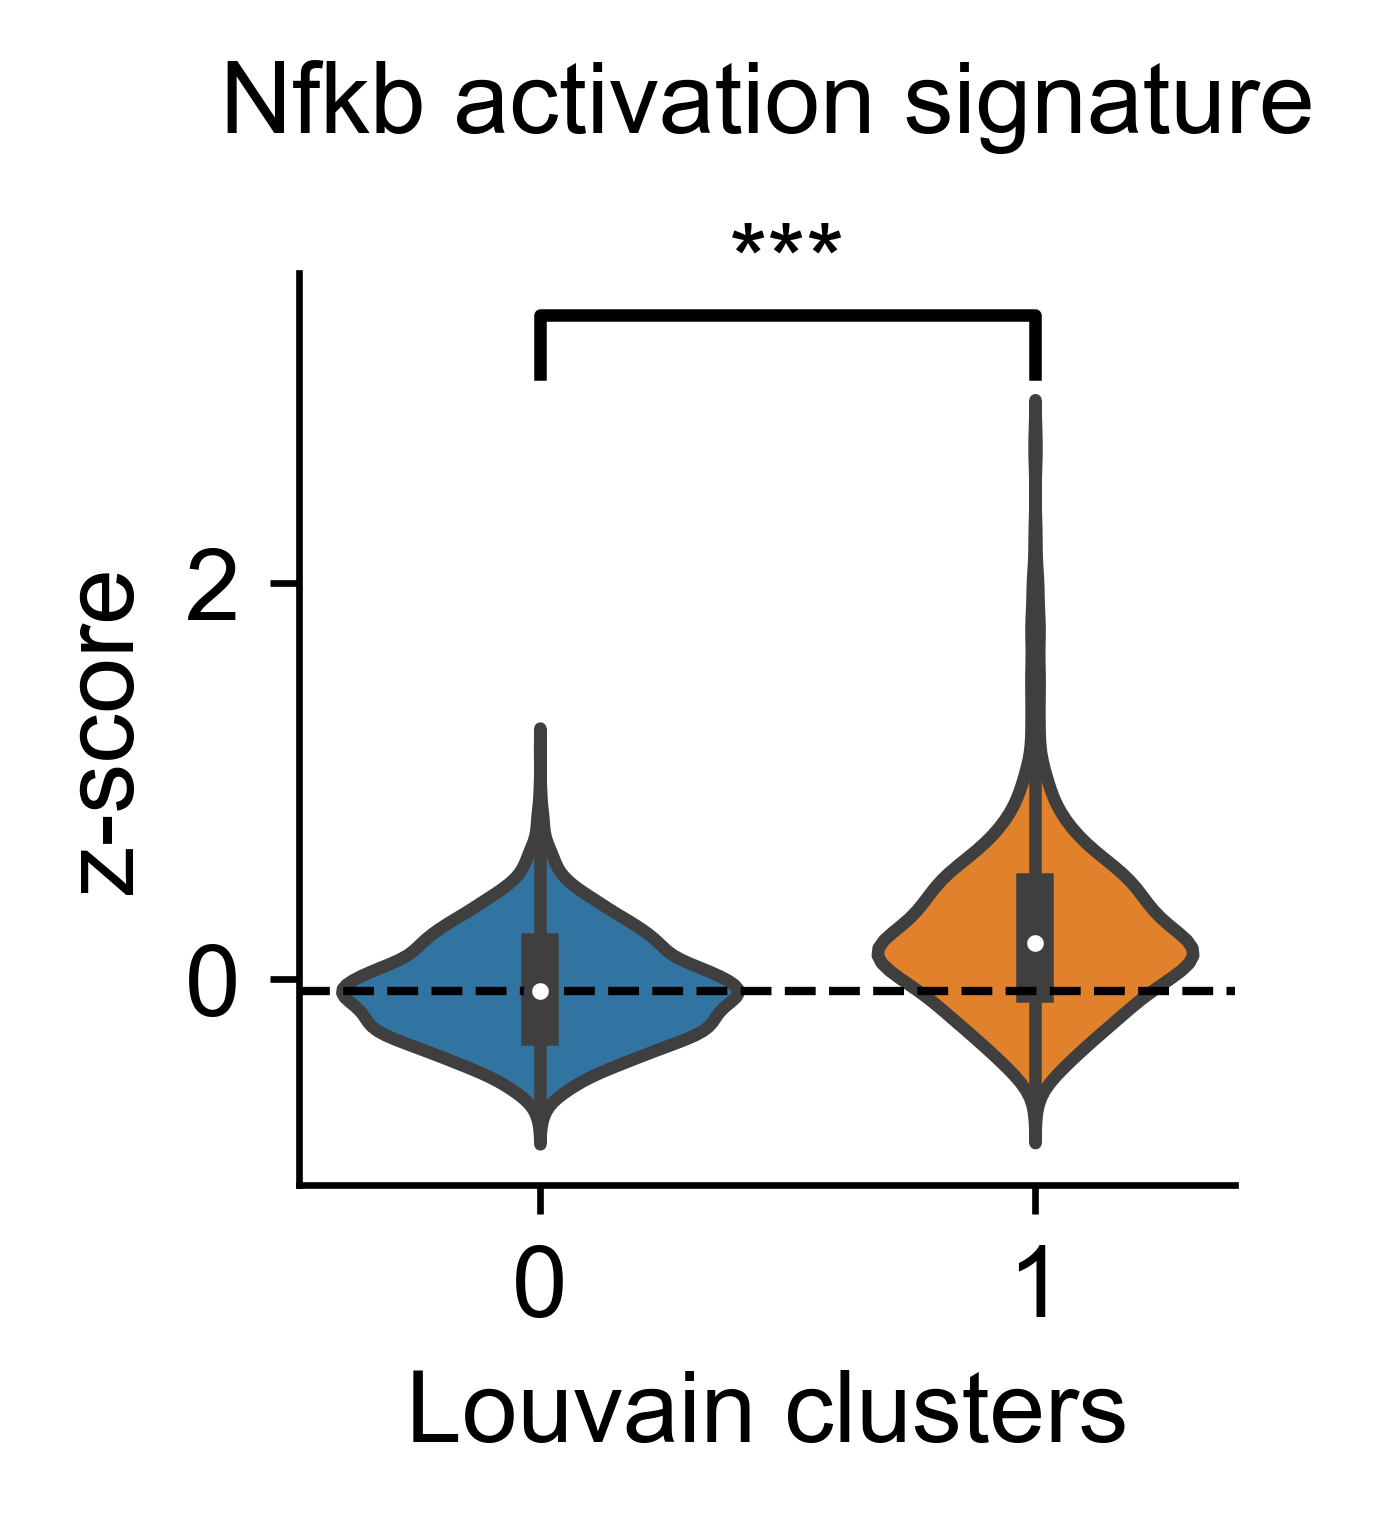

In [127]:
# Plot results
rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Nfkb activation signature', x='louvain_r0.2', data=adata_at2.obs)
despine(right=True)
plt.title('Nfkb activation signature', fontsize=12, y=1.1)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(-0.059787, color='black', linestyle='dashed', linewidth = 1)

# statistical annotation
x1, x2 = 0, 1  
y, h, col = adata_at2.obs['Nfkb activation signature'].max() + 0.3, 0.3, 'k' # bar location
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/Nfkb_activation_signature_expression.png', bbox_inches="tight")

## Nfkb all clusters

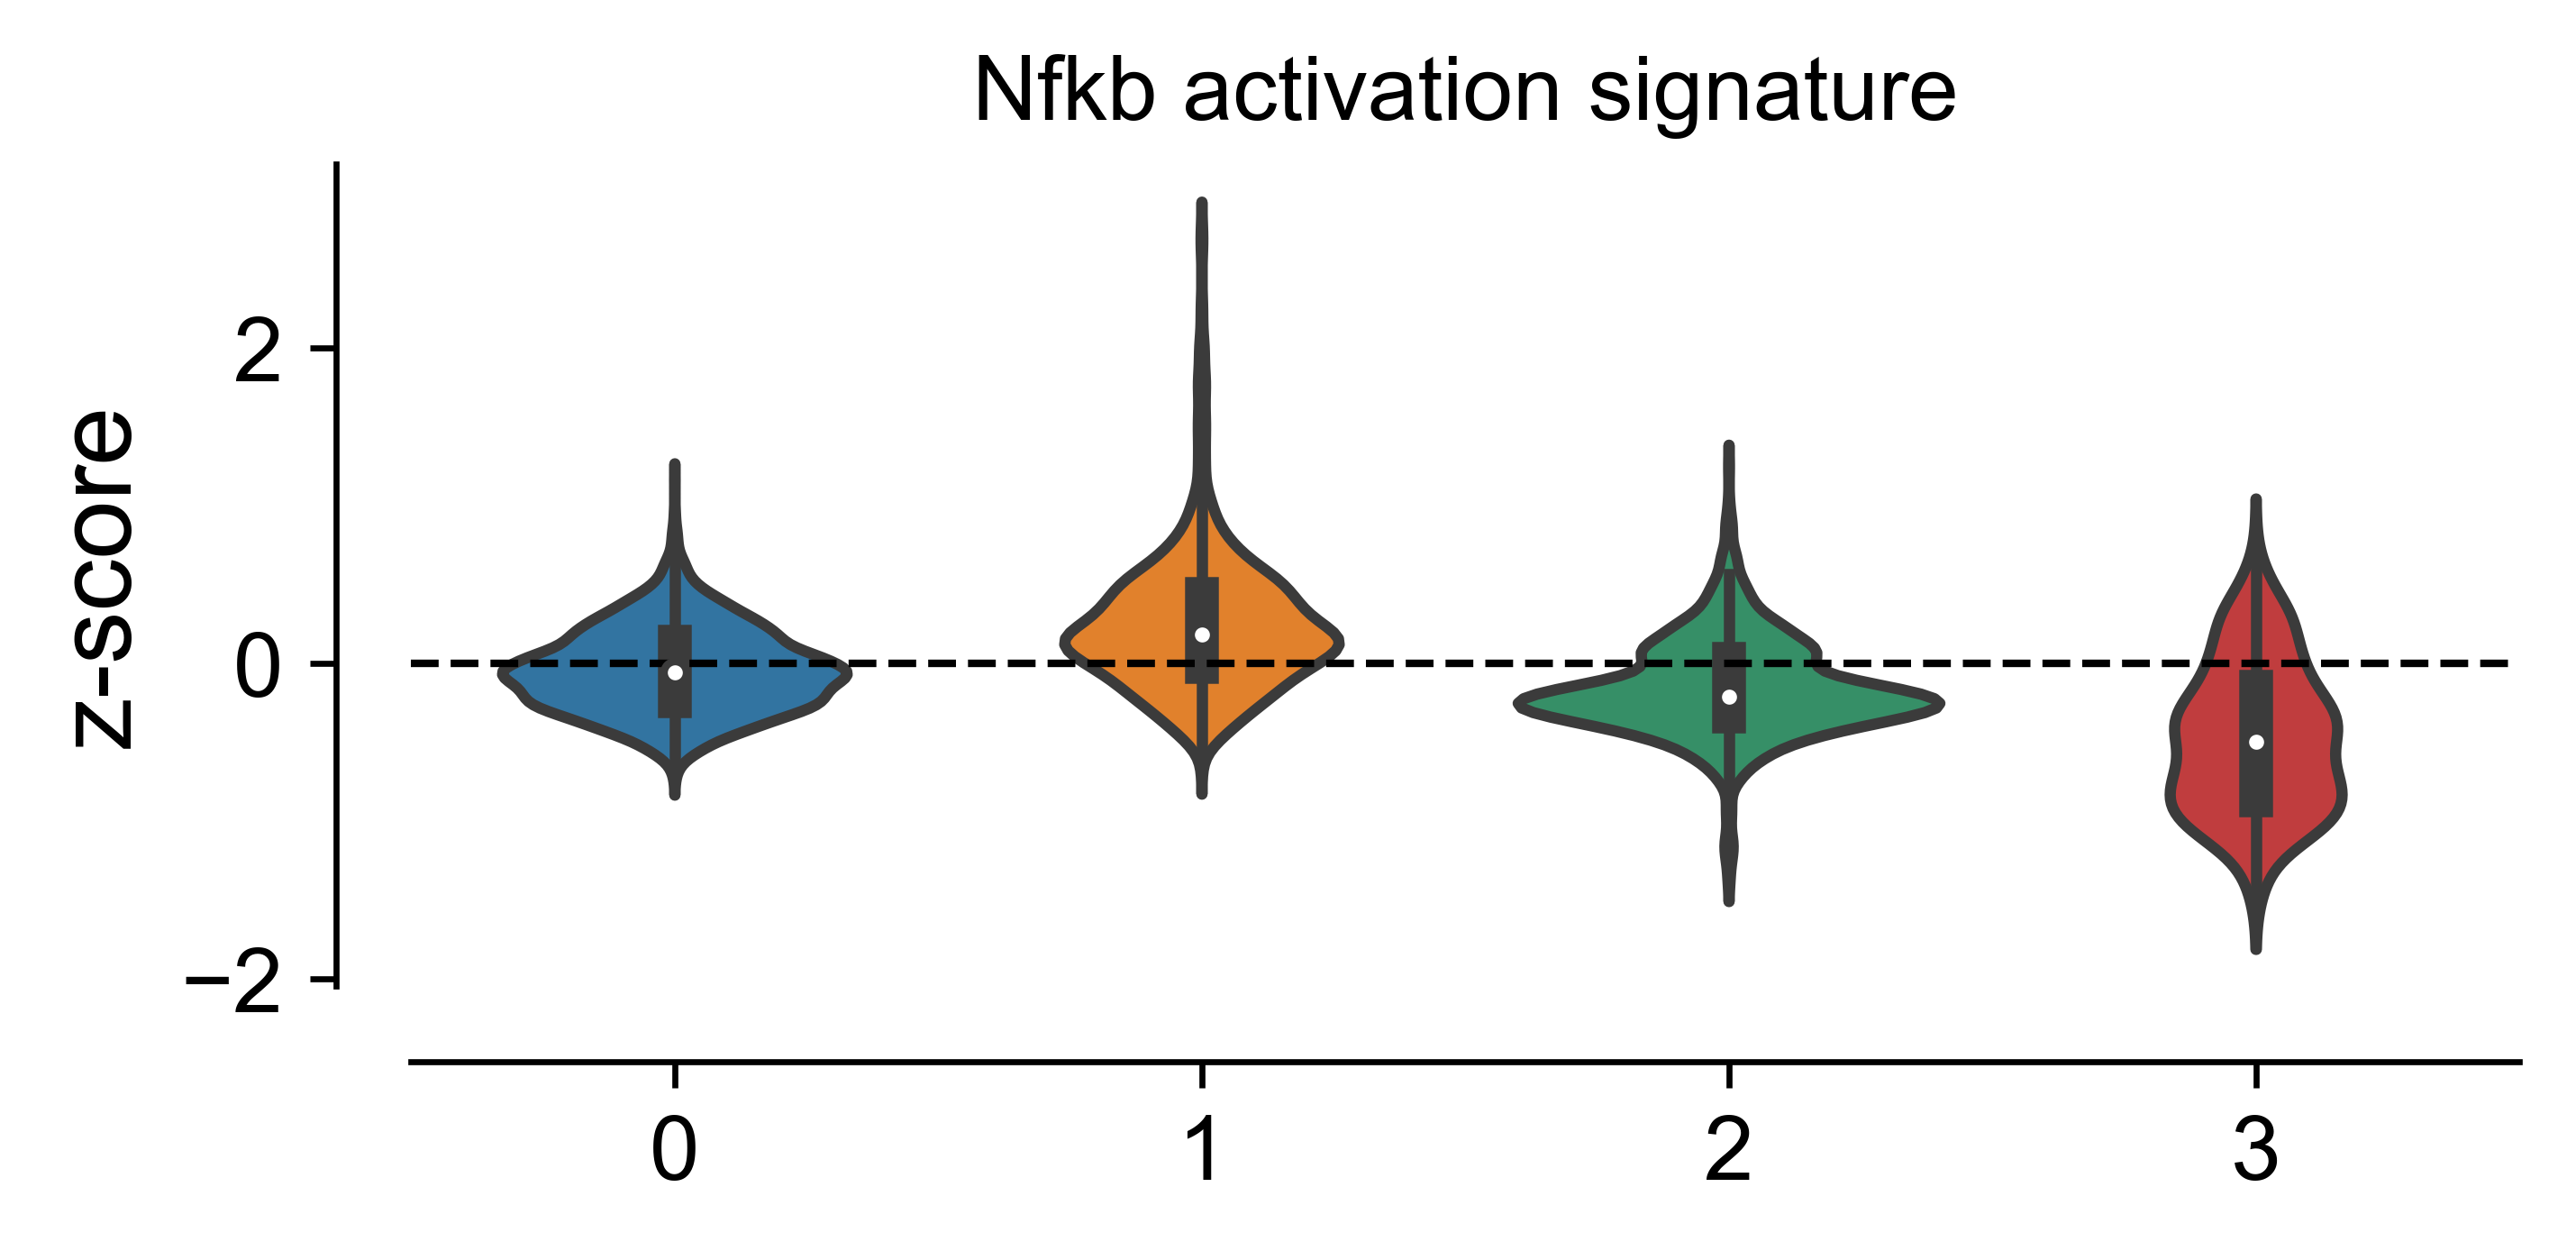

In [280]:
# Plot results
rcParams['figure.figsize'] = 5,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Nfkb activation signature', x='louvain_r0.2', data=adata_subset.obs)
despine(right=True, offset=10)
plt.title('Nfkb activation signature', fontsize=12, y=1)
plt.ylabel('z-score', fontsize=14)
plt.xlabel('', fontsize=14)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(0, color='black', linestyle='dashed', linewidth = 1)

plt.savefig('./figures/Nfkb_signature_all clusters.png', bbox_inches="tight", dpi=300)

## Proliferation signature

In [129]:
df=adata_at2.obs
df_1 = pd.pivot_table(df, values='Proliferation signature', index='index1', columns='louvain_r0.2')
df_1.median()

louvain_r0.2
0   -0.392679
1    0.128145
dtype: float64

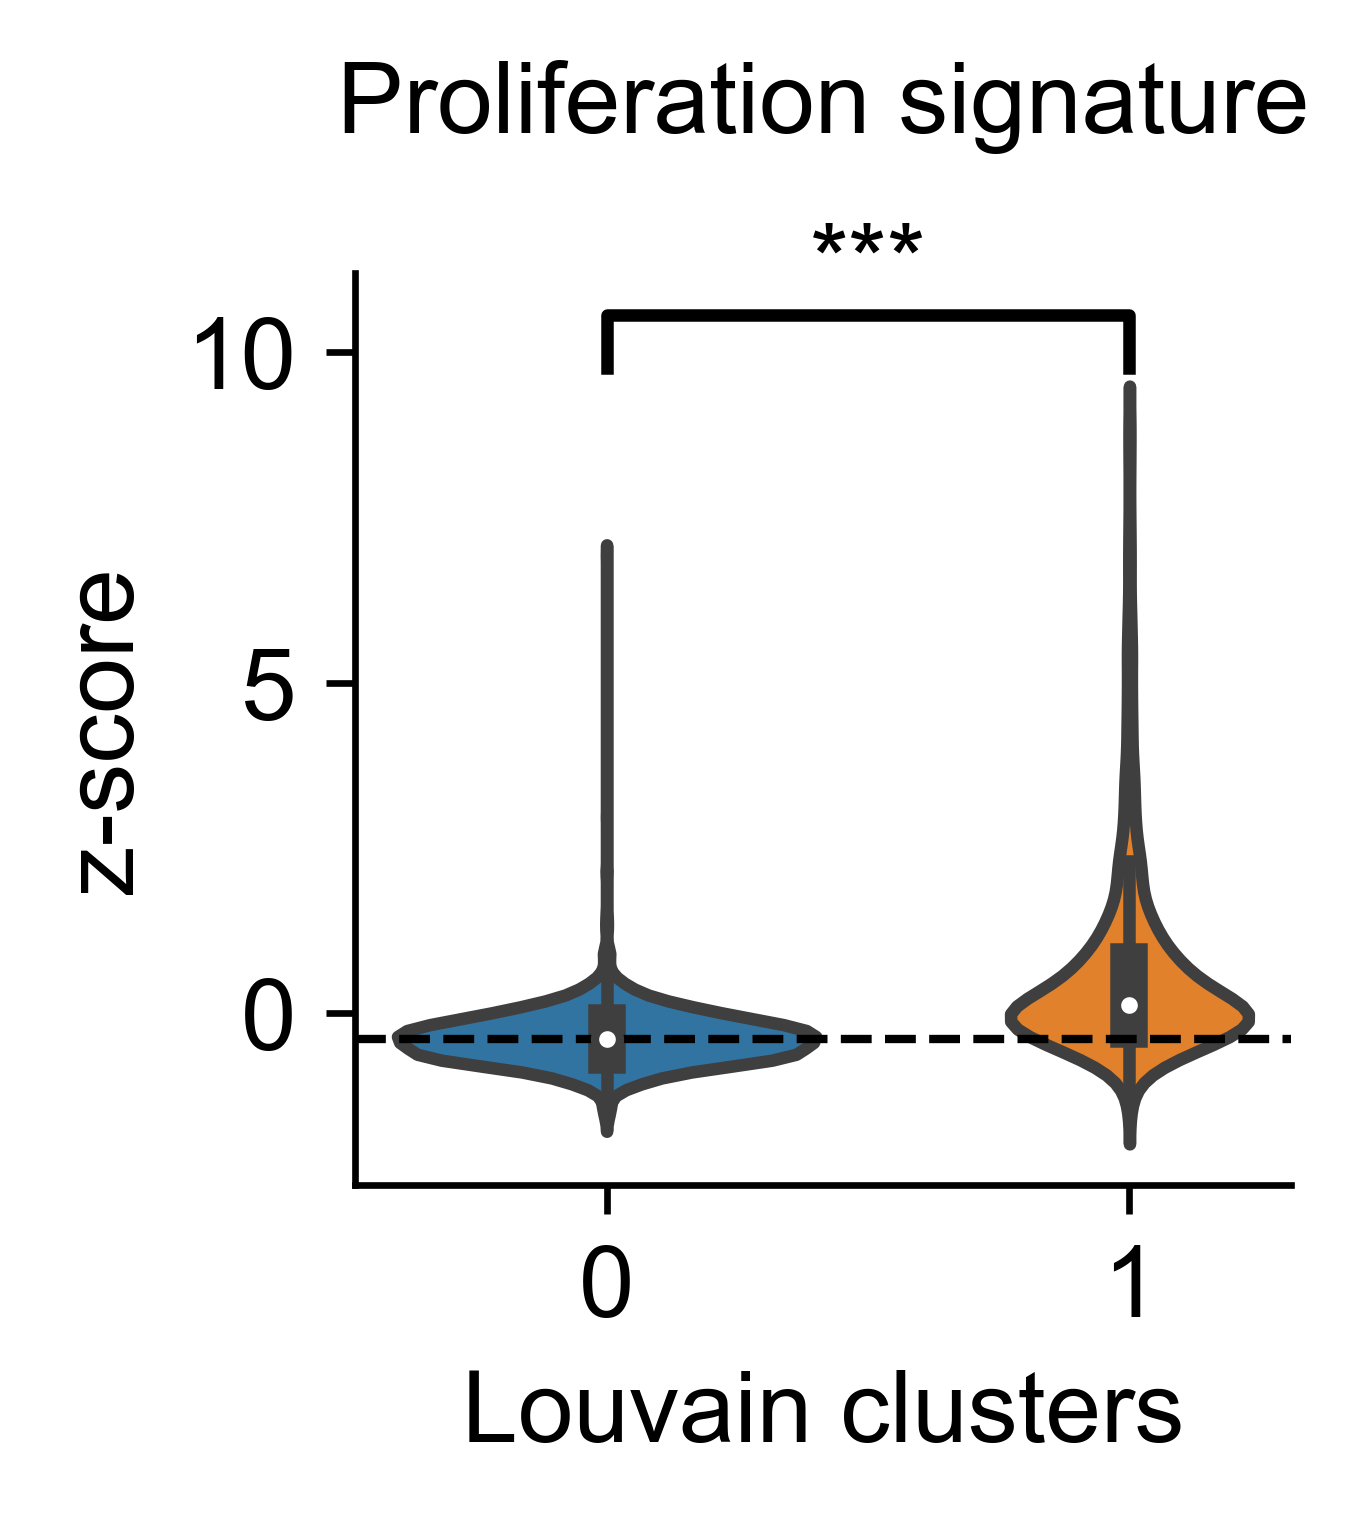

In [134]:
# Plot results
rcParams['figure.figsize'] = 2,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Proliferation signature', x='louvain_r0.2', data=adata_at2.obs)
despine(right=True)
plt.title('Proliferation signature', fontsize=12, y=1.1)
plt.ylabel('z-score', fontsize=12)
plt.xlabel('Louvain clusters', fontsize=12)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(-0.392679, color='black', linestyle='dashed', linewidth = 1)

# statistical annotation
x1, x2 = 0, 1  
y, h, col = adata_at2.obs['Proliferation signature'].max() + 0.8, 0.8, 'k' # bar location
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col, fontsize=12)

plt.savefig('./figures/proliferation_signature_expression.png', bbox_inches="tight")

# Proliferation all clusters

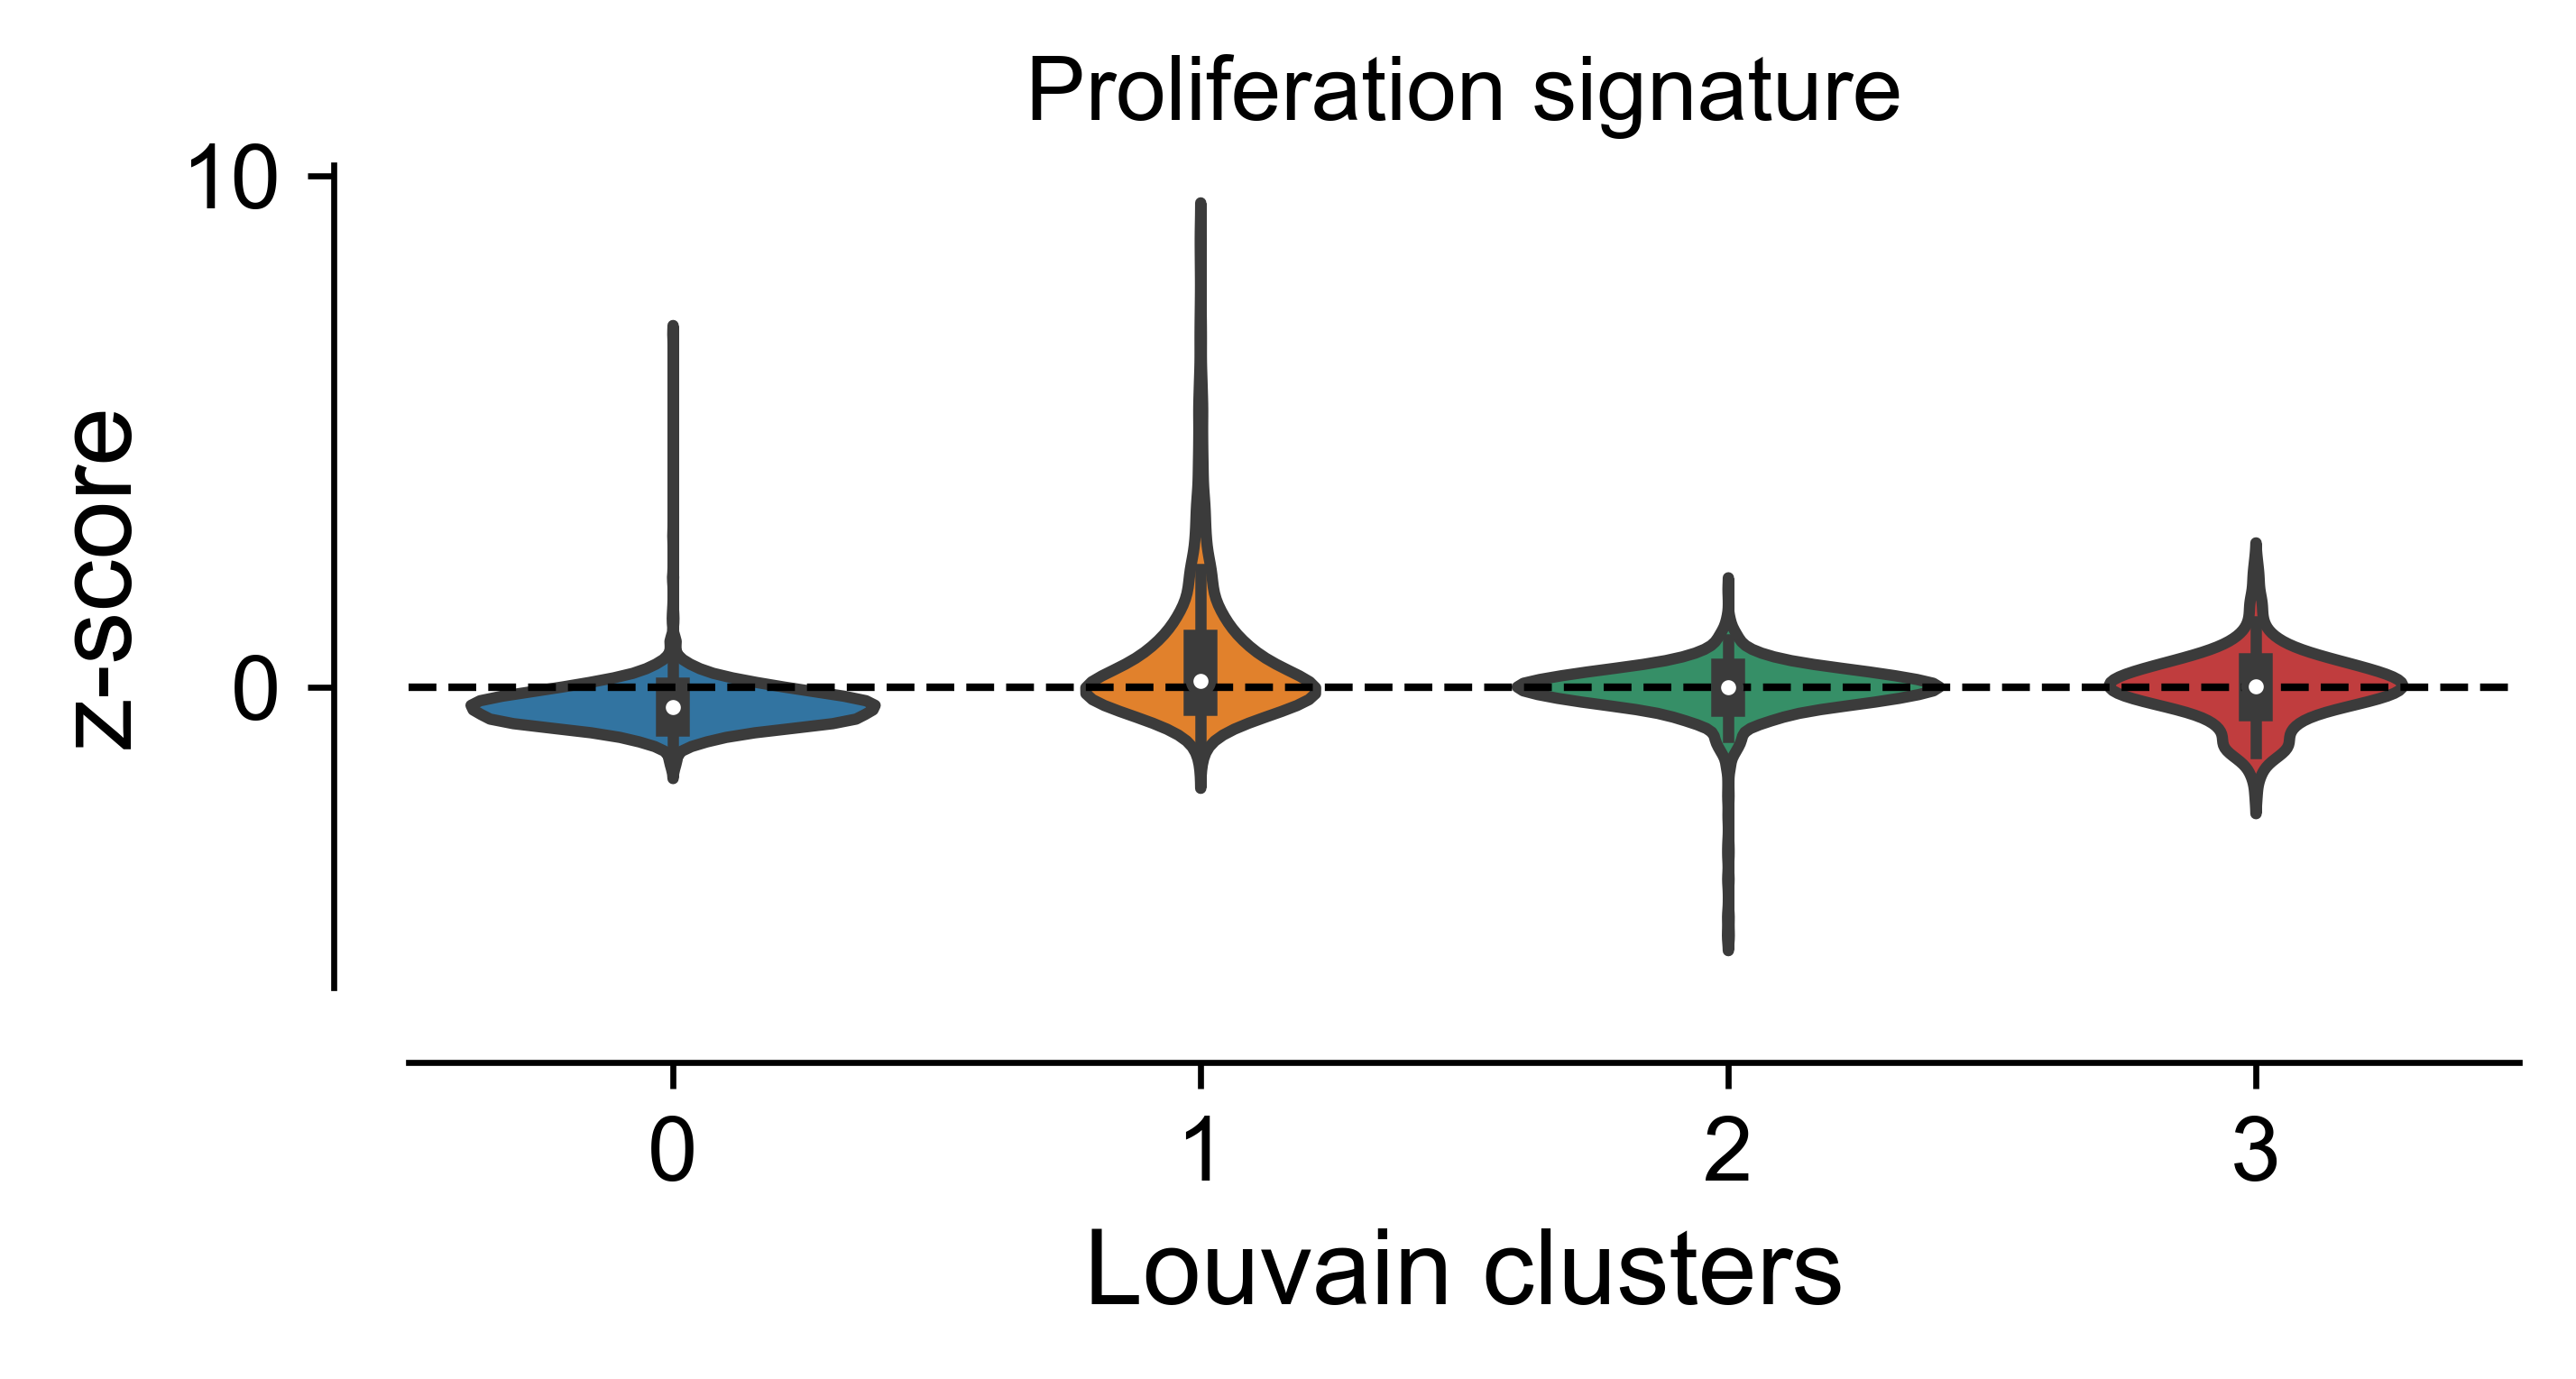

In [285]:
# Plot results
rcParams['figure.figsize'] = 5,2
with axes_style({'axes.grid': False}):
 ax = sb.violinplot(y='Proliferation signature', x='louvain_r0.2', data=adata_subset.obs)
despine(right=True, offset=10)
plt.title('Proliferation signature', fontsize=12, y=1)
plt.ylabel('z-score', fontsize=14)
plt.xlabel('Louvain clusters', fontsize=14)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.axhline(0, color='black', linestyle='dashed', linewidth = 1)

plt.savefig('./figures/Proliferation_signature_all clusters.png', bbox_inches="tight", dpi=300)

## Plot correlations

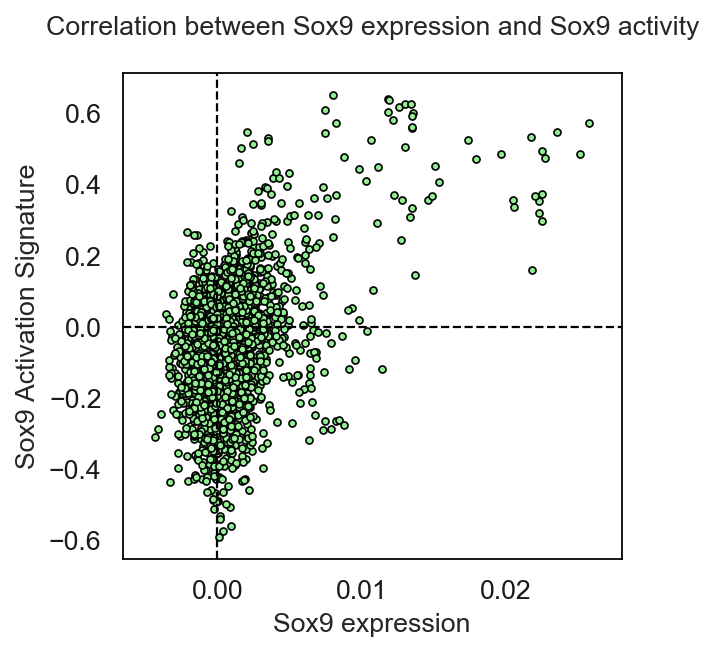

In [315]:
sc.settings.set_figure_params(dpi=80)

adata_cancer = adata_at2[adata_at2.obs['louvain_r0.2'].isin(['1'])] # subset the sftpc-high YFP+ cluster

y=adata_cancer.obs['Sox9_score']
x=adata_cancer.obs['Sox9']
color='lightgreen'
hue=None
legend=False
kwargs={"alpha":1,"s":10,'edgecolor':'black'}

rcParams['figure.figsize'] = 4,4
with axes_style({'axes.grid': False}):
 ax = sb.scatterplot(x=x, y=y, color=color,hue=hue, **kwargs)
plt.title('Correlation between Sox9 expression and Sox9 activity', fontsize=12, y=1.05)
plt.xlabel('Sox9 expression', fontsize=12)
plt.ylabel('Sox9 Activation Signature', fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.xticks(fontsize=12, rotation=0)
plt.axhline(0, color='black', linestyle='dashed', linewidth = 1)
plt.axvline(0, color='black', linestyle='dashed', linewidth = 1)
plt.savefig('./figures/sox9_correlation.png',bbox_inches='tight', dpi=300)

## Save the data

In [313]:
# Create h5ad files to save the data
results_file = './write/adata_epithelial.h5ad'  
subset_results_file = './write/adata_subset.h5ad'

In [320]:
# Save the data
adata.write(results_file)
adata_subset.write(subset_results_file)